In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = 'Pharma LSTM Experiment'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import math

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

In [5]:
def pred_acc(actual, predictions, logger):

    hold = 0
    sell = 0
    buy = 0
    pred_hold = 0
    pred_sell = 0
    pred_buy = 0
    buy_buy = 0
    buy_sell = 0
    buy_hold = 0
    sell_buy = 0
    sell_sell = 0
    sell_hold = 0
    hold_buy = 0
    hold_sell = 0
    hold_hold = 0

    for i in range (0,len(actual)):
        if actual[i]==1 and predictions[i] == 1:
            buy_buy += 1
            buy += 1
            pred_buy += 1
        elif actual[i]==1 and predictions[i] == 0:
            buy_sell += 1
            buy += 1
            pred_sell += 1
        elif actual[i]==1 and predictions[i] == 2:
            buy_hold += 1
            buy += 1
            pred_hold += 1
        elif actual[i]==0 and predictions[i] == 1:
            sell_buy += 1
            sell += 1
            pred_buy += 1
        elif actual[i]==0 and predictions[i] == 0:
            sell_sell += 1
            sell += 1
            pred_sell += 1
        elif actual[i]==0 and predictions[i] == 2:
            sell_hold += 1
            sell += 1
            pred_hold += 1
        elif actual[i]==2 and predictions[i] == 1:
            hold_buy += 1
            hold += 1
            pred_buy += 1
        elif actual[i]==2 and predictions[i] == 0:
            hold_sell += 1
            hold += 1
            pred_sell += 1
        elif actual[i]==2 and predictions[i] == 2:
            hold_hold += 1
            hold += 1
            pred_hold += 1

    print("number of predictions: " + str(len(actual)))
    print("actual predicted buys: " + str(buy_buy) )
    print("actual buys but predicted sell: " + str(buy_sell) )
    print("actual buys but predicted hold: " + str(buy_hold))
    print("actual sells but predicted buy: " + str(sell_buy) )
    print("actual predicted sells: " + str(sell_sell))
    print("actual sells but predicted hold: " + str(sell_hold) )
    print("actual holds but predicted buy: " + str(hold_buy) )
    print("actual holds but predicted sell: " + str(hold_sell))
    print("actual predicted holds: " + str(hold_hold) )
    
    if pred_buy !=0:
        Percentage_buys_correct = 100*buy_buy/pred_buy
    else:
        Percentage_buys_correct = 0
        
    if pred_sell !=0:
        Percentage_sells_correct = 100*sell_sell/pred_sell
    else:
        Percentage_sells_correct = 0
        
    if pred_hold !=0:
        Percentage_holds_correct = 100*hold_hold/pred_hold
    else:
        Percentage_holds_correct = 0

    print("Percentage buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage holds correct: " + str(Percentage_holds_correct) + "%")

    print("actual buys: " + str(buy))
    print("actual sells: " + str(sell))
    print("actual holds: " + str(hold))
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger


In [6]:
def correct_maxima_minima(predictions, price, logger):
    correct_maxima = 0 
    correct_minima = 0
    correct_hold = 0

    hold = 0
    buy = 0
    sell = 0

#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):
        if i < 4:
            prices = price[i:i+9]
            prices.sort(key = float)
#             if i == 0:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1

        else:
            prices = price[i:i+5]
            prices = prices + price[i-4:i] 
            prices.sort(key = float)
#             if i == 10:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1
                    
    if buy !=0:
        Percentage_buys_correct = 100*correct_minima/buy
    else:
        Percentage_buys_correct = 0
        
    if sell !=0:
        Percentage_sells_correct = 100*correct_maxima/sell
    else:
        Percentage_sells_correct = 0
        
    if hold !=0:
        Percentage_holds_correct = 100*correct_hold/hold
    else:
        Percentage_holds_correct = 0

    print("Percentage low buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage high sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage mid holds correct: " + str(Percentage_holds_correct) + "%")
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger

In [7]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

## Prepare Test Data

In [8]:
nr_test_sets = ['VXRT','INO','NVAX']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("variation 7/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
        
    X = sequential
    X  = np.array(X).reshape(-1, 15, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d    EMA_12   willr_14    OBV_7  labels
Date                                                         
2019-01-22         1.95  2.010695 -57.142843  16000.0     2.0
2019-01-23         1.85  1.985973 -69.230761    800.0     1.0
2019-01-24         1.81  1.958900 -75.384620 -18800.0     2.0
2019-01-25         1.83  1.939069 -72.307681  60700.0     2.0
2019-01-28         1.87  1.928443 -71.666669  82700.0     2.0
            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2019-01-22         5.09  4.742046  -0.840315  6313800.0     2.0
2019-01-23         5.00  4.781732  -8.403355  5520600.0     2.0
2019-01-24         4.78  4.781465 -35.164808  4872000.0     2.0
2019-01-25         5.01  4.816624 -11.111072  6179900.0     0.0
2019-01-28         5.10  4.860221  -1.639381  7036300.0     2.0
            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                 

In [9]:
r_test_sets = ['VXRT','INO','NVAX']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("variation 7/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
        
    X = sequential
    X  = np.array(X).reshape(-1, 15, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d    EMA_12   willr_14       OBV_7  labels
Date                                                            
2020-01-22         0.53  0.388757  -0.000000   7111600.0     2.0
2020-01-23         0.59  0.419718 -30.952393  27158800.0     2.0
2020-01-24         0.53  0.436684 -45.238107  23794300.0     2.0
2020-01-27         0.49  0.444887 -58.974362  21329000.0     2.0
2020-01-28         0.64  0.474904 -21.052641  31022300.0     2.0
            previous_1d    EMA_12   willr_14       OBV_7  labels
Date                                                            
2020-01-22         3.56  3.271874 -23.750009   7769400.0     2.0
2020-01-23         3.44  3.297739 -38.749995   5767800.0     2.0
2020-01-24         3.84  3.381164 -22.608698  18081400.0     2.0
2020-01-27         4.24  3.513293 -26.285720  42708100.0     0.0
2020-01-28         5.32  3.791248 -21.649473  83567200.0     2.0
            previous_1d    EMA_12   willr_14        OBV_7  labels
Date                    

## Train Vaxart, Inc Stock Data

### Creating Training Data and Model

            previous_1d      EMA_12   willr_14    OBV_7  labels
Date                                                           
2000-01-21      437.250  350.035133  -6.976744  42909.0     0.0
2000-01-24      515.625  375.510497 -10.606061  67630.0     2.0
2000-01-25      424.875  383.105036 -43.939394  53407.0     2.0
2000-01-26      453.750  393.973492 -33.333333  57201.0     2.0
2000-01-27      420.750  398.092955 -50.000000  54669.0     2.0


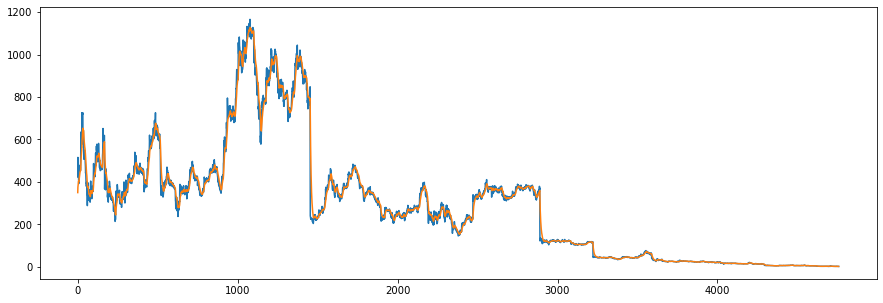

(4745, 15, 4)

In [10]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []

seed = 10
df = pd.read_csv('variation 7/initial_indicators/VXRT_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)

X.shape

In [11]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [12]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [13]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [15]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    nr_log  = pd.DataFrame(columns = column_names)
    r_log  = pd.DataFrame(columns = column_names)
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        callbacks=[tensorboard],
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    test_sets = ['VXRT','INO','NVAX']
    for name in test_sets:
        
        print('\n')
        print("Non-Recession")
        print('\n')
        
        X = nr_test_data['{}_X'.format(name)]
        y = nr_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("variation 7/initial_indicators/{}_data_test.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(nr_log)
        nr_log.loc[df_length] = logger
        print(nr_log.head(20))
        logger = []
        
        print('\n')
        print("Recession")
        print('\n')
        
        X = r_test_data['{}_X'.format(name)]
        y = r_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("variation 7/initial_indicators/{}_data_test2.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(r_log)
        r_log.loc[df_length] = logger
        print(r_log.head(20))
        logger = []

    nr_log.to_csv('{}_{}_{}epochs.csv'.format(experiment,'VaxartModel',epochs))
    nr_log_hist['{}_epochs_logs'.format(epochs)] = nr_log
    r_log.to_csv('{}_{}_{}epochs.csv'.format(experiment,'VaxartModel',epochs))
    r_log_hist['{}_epochs_logs'.format(epochs)] = r_log
    epochs = epochs + 20

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 6.8768115942028984, 1: 7.230476190476191, 2: 0.3681505188633498}



RUNNING EPOCHS 0 - 20



Epoch 1/20
 1/30 [>.............................] - ETA: 0s - loss: 0.3232 - accuracy: 0.5859 - mse: 0.3087 - weighted_accuracy: 0.2430 - weighted_mse: 0.4080WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
30/30 [==============================] - 1s 49ms/step - loss: 0.2936 - accuracy: 0.5192 - mse: 0.4518 - weighted_accuracy: 0.3142 - weighted_mse: 0.5380 - val_loss: 0.2993 - val_accuracy: 0.0464 - val_mse: 0.3546 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.3546
Epoch 2/20
30/30 [==============================] - 0s 10ms/step - loss: 0.2119 - accuracy: 0.3596 - mse: 0.7794 - weighted_accuracy: 0.4162 - weighted_mse: 0.7783 - val_loss: 0.2902 

7/7 [==============================] - 0s 5ms/step - loss: 0.2001 - accuracy: 0.2329 - mse: 1.3018 - weighted_accuracy: 0.2329 - weighted_mse: 1.3018
Test loss: 0.20012745261192322
Test accuracy: 0.232876718044281


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 5
actual sells but predicted hold: 1
actual holds but predicted buy: 102
actual holds but predicted sell: 62
actual predicted holds: 39
Percentage buys correct: 6.306306306306307%
Percentage sells correct: 7.462686567164179%
Percentage holds correct: 95.1219512195122%
actual buys: 8
actual sells: 8
actual holds: 203


Percentage low buys correct: 41.81818181818182%
Percentage high sells correct: 49.25373134328358%
Percentage mid holds correct: 87.8048780487805%


Capital: 100
Share price: $0.013138736570059003
Shares owned at the moment: 7590
Cash capital at the moment: $0.002751154193603611


Price

7/7 [==============================] - 0s 4ms/step - loss: 0.1907 - accuracy: 0.3242 - mse: 1.2566 - weighted_accuracy: 0.3242 - weighted_mse: 1.2566
Test loss: 0.19073379039764404
Test accuracy: 0.32420089840888977


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 5
actual holds but predicted buy: 94
actual holds but predicted sell: 46
actual predicted holds: 60
Percentage buys correct: 5.9405940594059405%
Percentage sells correct: 9.615384615384615%
Percentage holds correct: 90.9090909090909%
actual buys: 8
actual sells: 11
actual holds: 200


Percentage low buys correct: 49.504950495049506%
Percentage high sells correct: 53.84615384615385%
Percentage mid holds correct: 86.15384615384616%


Capital: 100
Share price: $0.011763675119632519
Shares owned at the moment: 8477
Cash capital at the moment: $0.005094157405039823




7/7 [==============================] - 0s 4ms/step - loss: 0.1943 - accuracy: 0.2192 - mse: 1.2328 - weighted_accuracy: 0.2192 - weighted_mse: 1.2328
Test loss: 0.1942659318447113
Test accuracy: 0.21917808055877686


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 3
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 79
actual holds but predicted sell: 85
actual predicted holds: 37
Percentage buys correct: 4.651162790697675%
Percentage sells correct: 7.526881720430108%
Percentage holds correct: 92.5%
actual buys: 8
actual sells: 10
actual holds: 201


Percentage low buys correct: 41.86046511627907%
Percentage high sells correct: 43.47826086956522%
Percentage mid holds correct: 85.0%


Capital: 100
Share price: $0.04473193603517206
Shares owned at the moment: 2229
Cash capital at the moment: $0.018318992689884794


Price increase from previousl

30/30 [==============================] - 0s 13ms/step - loss: 0.1396 - accuracy: 0.4476 - mse: 1.5056 - weighted_accuracy: 0.7246 - weighted_mse: 1.4333 - val_loss: 0.1847 - val_accuracy: 0.3888 - val_mse: 1.4998 - val_weighted_accuracy: 0.3888 - val_weighted_mse: 1.4998
Epoch 10/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1392 - accuracy: 0.4708 - mse: 1.4948 - weighted_accuracy: 0.7196 - weighted_mse: 1.4361 - val_loss: 0.1840 - val_accuracy: 0.3952 - val_mse: 1.5115 - val_weighted_accuracy: 0.3952 - val_weighted_mse: 1.5115
Epoch 11/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1383 - accuracy: 0.4344 - mse: 1.5200 - weighted_accuracy: 0.7249 - weighted_mse: 1.4392 - val_loss: 0.1917 - val_accuracy: 0.3646 - val_mse: 1.5318 - val_weighted_accuracy: 0.3646 - val_weighted_mse: 1.5318
Epoch 12/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1367 - accuracy: 0.4939 - mse: 1.5156 - weighted_accuracy: 0.7453 - weighted_mse: 1.

7/7 [==============================] - 0s 5ms/step - loss: 0.1914 - accuracy: 0.4566 - mse: 1.8357 - weighted_accuracy: 0.4566 - weighted_mse: 1.8357
Test loss: 0.19137218594551086
Test accuracy: 0.456620991230011


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 2
actual predicted sells: 4
actual sells but predicted hold: 2
actual holds but predicted buy: 39
actual holds but predicted sell: 71
actual predicted holds: 93
Percentage buys correct: 6.818181818181818%
Percentage sells correct: 5.2631578947368425%
Percentage holds correct: 93.93939393939394%
actual buys: 8
actual sells: 8
actual holds: 203


Percentage low buys correct: 46.51162790697674%
Percentage high sells correct: 44.73684210526316%
Percentage mid holds correct: 86.86868686868686%


Capital: 100
Share price: $0.018788448926188438
Shares owned at the moment: 5307
Cash capital at the moment: $0.015498227976934231


Pri

7/7 [==============================] - 0s 4ms/step - loss: 0.1696 - accuracy: 0.5068 - mse: 1.7288 - weighted_accuracy: 0.5068 - weighted_mse: 1.7288
Test loss: 0.16963456571102142
Test accuracy: 0.5068492889404297


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 4
actual holds but predicted buy: 43
actual holds but predicted sell: 57
actual predicted holds: 100
Percentage buys correct: 10.204081632653061%
Percentage sells correct: 9.375%
Percentage holds correct: 94.33962264150944%
actual buys: 8
actual sells: 11
actual holds: 200


Percentage low buys correct: 53.06122448979592%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 89.52380952380952%


Capital: 100
Share price: $0.03857143433816657
Shares owned at the moment: 2585
Cash capital at the moment: $0.01864755198796786


Price increase from previou

7/7 [==============================] - 0s 4ms/step - loss: 0.1999 - accuracy: 0.3562 - mse: 1.8072 - weighted_accuracy: 0.3562 - weighted_mse: 1.8072
Test loss: 0.19985587894916534
Test accuracy: 0.3561643958091736


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 5
actual holds but predicted buy: 37
actual holds but predicted sell: 93
actual predicted holds: 71
Percentage buys correct: 5.128205128205129%
Percentage sells correct: 5.05050505050505%
Percentage holds correct: 87.65432098765432%
actual buys: 8
actual sells: 10
actual holds: 201


Percentage low buys correct: 53.84615384615385%
Percentage high sells correct: 40.816326530612244%
Percentage mid holds correct: 81.48148148148148%


Capital: 100
Share price: $0.08849650193805968
Shares owned at the moment: 1126
Cash capital at the moment: $0.07890939949359677


Pric

30/30 [==============================] - 0s 12ms/step - loss: 0.1140 - accuracy: 0.5880 - mse: 1.8671 - weighted_accuracy: 0.8030 - weighted_mse: 1.8375 - val_loss: 0.1767 - val_accuracy: 0.5068 - val_mse: 2.0397 - val_weighted_accuracy: 0.5068 - val_weighted_mse: 2.0397
Epoch 14/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1147 - accuracy: 0.5803 - mse: 1.8911 - weighted_accuracy: 0.8050 - weighted_mse: 1.8510 - val_loss: 0.1916 - val_accuracy: 0.4658 - val_mse: 1.9732 - val_weighted_accuracy: 0.4658 - val_weighted_mse: 1.9732
Epoch 15/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1132 - accuracy: 0.5803 - mse: 1.8908 - weighted_accuracy: 0.8105 - weighted_mse: 1.8515 - val_loss: 0.1628 - val_accuracy: 0.5848 - val_mse: 1.9277 - val_weighted_accuracy: 0.5848 - val_weighted_mse: 1.9277
Epoch 16/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1123 - accuracy: 0.6188 - mse: 1.8918 - weighted_accuracy: 0.8090 - weighted_mse: 1.

7/7 [==============================] - 0s 3ms/step - loss: 0.1681 - accuracy: 0.5367 - mse: 1.9817 - weighted_accuracy: 0.5367 - weighted_mse: 1.9817
Test loss: 0.16808383166790009
Test accuracy: 0.536697268486023


number of predictions: 218
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 5
actual holds but predicted buy: 43
actual holds but predicted sell: 45
actual predicted holds: 111
Percentage buys correct: 4.444444444444445%
Percentage sells correct: 8.16326530612245%
Percentage holds correct: 89.51612903225806%
actual buys: 10
actual sells: 9
actual holds: 199


Percentage low buys correct: 53.333333333333336%
Percentage high sells correct: 57.142857142857146%
Percentage mid holds correct: 78.04878048780488%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from p

7/7 [==============================] - 0s 4ms/step - loss: 0.1743 - accuracy: 0.5275 - mse: 2.0584 - weighted_accuracy: 0.5275 - weighted_mse: 2.0584
Test loss: 0.17434914410114288
Test accuracy: 0.5275229215621948


number of predictions: 218
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 5
actual sells but predicted buy: 2
actual predicted sells: 3
actual sells but predicted hold: 3
actual holds but predicted buy: 66
actual holds but predicted sell: 26
actual predicted holds: 109
Percentage buys correct: 4.225352112676056%
Percentage sells correct: 10.0%
Percentage holds correct: 93.16239316239316%
actual buys: 9
actual sells: 8
actual holds: 201


Percentage low buys correct: 47.88732394366197%
Percentage high sells correct: 53.333333333333336%
Percentage mid holds correct: 83.62068965517241%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from previously bou

Epoch 1/20
30/30 [==============================] - 0s 15ms/step - loss: 0.1076 - accuracy: 0.6162 - mse: 1.9851 - weighted_accuracy: 0.8117 - weighted_mse: 1.9767 - val_loss: 0.1896 - val_accuracy: 0.4784 - val_mse: 2.0054 - val_weighted_accuracy: 0.4784 - val_weighted_mse: 2.0054
Epoch 2/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1066 - accuracy: 0.6120 - mse: 2.0214 - weighted_accuracy: 0.8224 - weighted_mse: 2.0028 - val_loss: 0.1812 - val_accuracy: 0.5090 - val_mse: 2.1104 - val_weighted_accuracy: 0.5090 - val_weighted_mse: 2.1104
Epoch 3/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1060 - accuracy: 0.6233 - mse: 2.0404 - weighted_accuracy: 0.8246 - weighted_mse: 2.0328 - val_loss: 0.1737 - val_accuracy: 0.5332 - val_mse: 2.1353 - val_weighted_accuracy: 0.5332 - val_weighted_mse: 2.1353
Epoch 4/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1055 - accuracy: 0.6409 - mse: 2.0509 - weighted_accuracy: 0.8379 - weighted

7/7 [==============================] - 0s 4ms/step - loss: 0.1947 - accuracy: 0.5114 - mse: 2.8936 - weighted_accuracy: 0.5114 - weighted_mse: 2.8936
Test loss: 0.19467294216156006
Test accuracy: 0.5114155411720276


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 2
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 4
actual sells but predicted hold: 3
actual holds but predicted buy: 40
actual holds but predicted sell: 59
actual predicted holds: 104
Percentage buys correct: 8.88888888888889%
Percentage sells correct: 6.153846153846154%
Percentage holds correct: 95.41284403669725%
actual buys: 8
actual sells: 8
actual holds: 203


Percentage low buys correct: 43.18181818181818%
Percentage high sells correct: 44.61538461538461%
Percentage mid holds correct: 85.3211009174312%


Capital: 100
Share price: $0.03636535426188572
Shares owned at the moment: 2742
Cash capital at the moment: $0.01198566009760782


Price 

7/7 [==============================] - 0s 4ms/step - loss: 0.1579 - accuracy: 0.6073 - mse: 2.6716 - weighted_accuracy: 0.6073 - weighted_mse: 2.6716
Test loss: 0.15786953270435333
Test accuracy: 0.6073059439659119


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 3
actual sells but predicted hold: 6
actual holds but predicted buy: 32
actual holds but predicted sell: 43
actual predicted holds: 125
Percentage buys correct: 12.820512820512821%
Percentage sells correct: 6.382978723404255%
Percentage holds correct: 93.98496240601504%
actual buys: 8
actual sells: 11
actual holds: 200


Percentage low buys correct: 51.282051282051285%
Percentage high sells correct: 51.06382978723404%
Percentage mid holds correct: 87.87878787878788%


Capital: 100
Share price: $0.03857143433816657
Shares owned at the moment: 2585
Cash capital at the moment: $0.01864755198796786


P

7/7 [==============================] - 0s 3ms/step - loss: 0.2137 - accuracy: 0.4384 - mse: 2.5551 - weighted_accuracy: 0.4384 - weighted_mse: 2.5551
Test loss: 0.21365922689437866
Test accuracy: 0.4383561611175537


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold: 5
actual sells but predicted buy: 1
actual predicted sells: 4
actual sells but predicted hold: 5
actual holds but predicted buy: 36
actual holds but predicted sell: 75
actual predicted holds: 90
Percentage buys correct: 5.128205128205129%
Percentage sells correct: 5.0%
Percentage holds correct: 90.0%
actual buys: 8
actual sells: 10
actual holds: 201


Percentage low buys correct: 48.717948717948715%
Percentage high sells correct: 40.50632911392405%
Percentage mid holds correct: 83.0%


Capital: 100
Share price: $0.01629370604497711
Shares owned at the moment: 6120
Cash capital at the moment: $0.008295932003107964


Price increase from previously bought: 159

30/30 [==============================] - 0s 14ms/step - loss: 0.0793 - accuracy: 0.7524 - mse: 2.8549 - weighted_accuracy: 0.8931 - weighted_mse: 2.9071 - val_loss: 0.1851 - val_accuracy: 0.5732 - val_mse: 2.9975 - val_weighted_accuracy: 0.5732 - val_weighted_mse: 2.9975
Epoch 13/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0782 - accuracy: 0.7561 - mse: 2.9480 - weighted_accuracy: 0.8997 - weighted_mse: 3.0218 - val_loss: 0.1770 - val_accuracy: 0.5901 - val_mse: 3.0748 - val_weighted_accuracy: 0.5901 - val_weighted_mse: 3.0748
Epoch 14/20
30/30 [==============================] - 0s 11ms/step - loss: 0.0787 - accuracy: 0.7574 - mse: 2.9886 - weighted_accuracy: 0.8948 - weighted_mse: 3.0471 - val_loss: 0.1935 - val_accuracy: 0.5648 - val_mse: 3.1540 - val_weighted_accuracy: 0.5648 - val_weighted_mse: 3.1540
Epoch 15/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0779 - accuracy: 0.7437 - mse: 2.9691 - weighted_accuracy: 0.8951 - weighted_mse: 3.

7/7 [==============================] - 0s 3ms/step - loss: 0.1598 - accuracy: 0.5963 - mse: 2.9420 - weighted_accuracy: 0.5963 - weighted_mse: 2.9420
Test loss: 0.15982115268707275
Test accuracy: 0.5963302850723267


number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 6
actual holds but predicted buy: 32
actual holds but predicted sell: 41
actual predicted holds: 126
Percentage buys correct: 3.0303030303030303%
Percentage sells correct: 6.818181818181818%
Percentage holds correct: 89.36170212765957%
actual buys: 10
actual sells: 9
actual holds: 199


Percentage low buys correct: 62.5%
Percentage high sells correct: 56.81818181818182%
Percentage mid holds correct: 79.43262411347517%


Capital: 100
Share price: $0.6644117473040075
Shares owned at the moment: 150
Cash capital at the moment: $0.06416805863595698


Price increase fr

7/7 [==============================] - 0s 3ms/step - loss: 0.1692 - accuracy: 0.5734 - mse: 3.3006 - weighted_accuracy: 0.5734 - weighted_mse: 3.3006
Test loss: 0.1691848188638687
Test accuracy: 0.5733944773674011


number of predictions: 218
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 1
actual predicted sells: 3
actual sells but predicted hold: 4
actual holds but predicted buy: 59
actual holds but predicted sell: 24
actual predicted holds: 118
Percentage buys correct: 6.25%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 92.91338582677166%
actual buys: 9
actual sells: 8
actual holds: 201


Percentage low buys correct: 54.6875%
Percentage high sells correct: 55.55555555555556%
Percentage mid holds correct: 84.12698412698413%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from previously bought: -77.187

Epoch 1/20
30/30 [==============================] - 1s 20ms/step - loss: 0.0734 - accuracy: 0.7729 - mse: 3.2232 - weighted_accuracy: 0.8920 - weighted_mse: 3.3126 - val_loss: 0.1785 - val_accuracy: 0.6048 - val_mse: 3.1902 - val_weighted_accuracy: 0.6048 - val_weighted_mse: 3.1902
Epoch 2/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0735 - accuracy: 0.7666 - mse: 3.2696 - weighted_accuracy: 0.9018 - weighted_mse: 3.3218 - val_loss: 0.1773 - val_accuracy: 0.6301 - val_mse: 3.3564 - val_weighted_accuracy: 0.6301 - val_weighted_mse: 3.3564
Epoch 3/20
30/30 [==============================] - 0s 15ms/step - loss: 0.0716 - accuracy: 0.7785 - mse: 3.2823 - weighted_accuracy: 0.9061 - weighted_mse: 3.3733 - val_loss: 0.1660 - val_accuracy: 0.6596 - val_mse: 3.5640 - val_weighted_accuracy: 0.6596 - val_weighted_mse: 3.5640
Epoch 4/20
30/30 [==============================] - 0s 14ms/step - loss: 0.0724 - accuracy: 0.7842 - mse: 3.3503 - weighted_accuracy: 0.9085 - weighted

7/7 [==============================] - 0s 4ms/step - loss: 0.2079 - accuracy: 0.5936 - mse: 4.6950 - weighted_accuracy: 0.5936 - weighted_mse: 4.6950
Test loss: 0.20789474248886108
Test accuracy: 0.5936073064804077


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 2
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 3
actual sells but predicted hold: 4
actual holds but predicted buy: 34
actual holds but predicted sell: 46
actual predicted holds: 123
Percentage buys correct: 10.256410256410257%
Percentage sells correct: 5.882352941176471%
Percentage holds correct: 95.34883720930233%
actual buys: 8
actual sells: 8
actual holds: 203


Percentage low buys correct: 50.0%
Percentage high sells correct: 41.1764705882353%
Percentage mid holds correct: 84.49612403100775%


Capital: 100
Share price: $0.013138736570059003
Shares owned at the moment: 7590
Cash capital at the moment: $0.002751154193603611


Price increase 

7/7 [==============================] - 0s 6ms/step - loss: 0.1503 - accuracy: 0.7215 - mse: 4.4002 - weighted_accuracy: 0.7215 - weighted_mse: 4.4002
Test loss: 0.15029285848140717
Test accuracy: 0.7214611768722534


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 17
actual holds but predicted sell: 32
actual predicted holds: 151
Percentage buys correct: 21.73913043478261%
Percentage sells correct: 5.714285714285714%
Percentage holds correct: 93.7888198757764%
actual buys: 8
actual sells: 11
actual holds: 200


Percentage low buys correct: 69.56521739130434%
Percentage high sells correct: 54.285714285714285%
Percentage mid holds correct: 87.5%


Capital: 100
Share price: $0.02446208384006391
Shares owned at the moment: 4076
Cash capital at the moment: $0.018350770136237315


Price increase 

7/7 [==============================] - 0s 5ms/step - loss: 0.2098 - accuracy: 0.5616 - mse: 3.8297 - weighted_accuracy: 0.5616 - weighted_mse: 3.8297
Test loss: 0.20983260869979858
Test accuracy: 0.5616438388824463


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 7
actual holds but predicted buy: 30
actual holds but predicted sell: 54
actual predicted holds: 117
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 5.172413793103448%
Percentage holds correct: 91.40625%
actual buys: 8
actual sells: 10
actual holds: 201


Percentage low buys correct: 51.515151515151516%
Percentage high sells correct: 36.8421052631579%
Percentage mid holds correct: 85.9375%


Capital: 100
Share price: $0.011748252914169829
Shares owned at the moment: 8488
Cash capital at the moment: $0.006601545003931619


Price increase from 

30/30 [==============================] - 0s 10ms/step - loss: 0.0513 - accuracy: 0.8522 - mse: 4.8299 - weighted_accuracy: 0.9439 - weighted_mse: 4.7941 - val_loss: 0.1866 - val_accuracy: 0.6902 - val_mse: 5.0994 - val_weighted_accuracy: 0.6902 - val_weighted_mse: 5.0994
Epoch 13/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0510 - accuracy: 0.8564 - mse: 4.9601 - weighted_accuracy: 0.9454 - weighted_mse: 4.9465 - val_loss: 0.1767 - val_accuracy: 0.6891 - val_mse: 5.2094 - val_weighted_accuracy: 0.6891 - val_weighted_mse: 5.2094
Epoch 14/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0516 - accuracy: 0.8596 - mse: 5.0471 - weighted_accuracy: 0.9395 - weighted_mse: 4.9976 - val_loss: 0.2043 - val_accuracy: 0.6333 - val_mse: 5.1270 - val_weighted_accuracy: 0.6333 - val_weighted_mse: 5.1270
Epoch 15/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0515 - accuracy: 0.8477 - mse: 4.9632 - weighted_accuracy: 0.9421 - weighted_mse: 4.

7/7 [==============================] - 0s 4ms/step - loss: 0.1547 - accuracy: 0.6835 - mse: 4.3190 - weighted_accuracy: 0.6835 - weighted_mse: 4.3190
Test loss: 0.15474452078342438
Test accuracy: 0.6834862232208252


number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 6
actual holds but predicted buy: 29
actual holds but predicted sell: 24
actual predicted holds: 146
Percentage buys correct: 3.225806451612903%
Percentage sells correct: 7.6923076923076925%
Percentage holds correct: 90.6832298136646%
actual buys: 10
actual sells: 9
actual holds: 199


Percentage low buys correct: 53.333333333333336%
Percentage high sells correct: 65.38461538461539%
Percentage mid holds correct: 81.36645962732919%


Capital: 100
Share price: $0.6644117473040075
Shares owned at the moment: 150
Cash capital at the moment: $0.06416805863595698


Pric

7/7 [==============================] - 0s 4ms/step - loss: 0.2066 - accuracy: 0.6256 - mse: 4.4559 - weighted_accuracy: 0.6256 - weighted_mse: 4.4559
Test loss: 0.20655089616775513
Test accuracy: 0.6255707740783691


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 1
actual predicted sells: 3
actual sells but predicted hold: 6
actual holds but predicted buy: 30
actual holds but predicted sell: 40
actual predicted holds: 131
Percentage buys correct: 8.823529411764707%
Percentage sells correct: 6.818181818181818%
Percentage holds correct: 92.90780141843972%
actual buys: 8
actual sells: 10
actual holds: 201


Percentage low buys correct: 44.11764705882353%
Percentage high sells correct: 43.18181818181818%
Percentage mid holds correct: 86.42857142857143%


Capital: 100
Share price: $0.016060606026923996
Shares owned at the moment: 6209
Cash capital at the moment: $0.00546634607069052


Pr

30/30 [==============================] - 0s 10ms/step - loss: 0.0426 - accuracy: 0.8767 - mse: 5.9408 - weighted_accuracy: 0.9546 - weighted_mse: 5.8081 - val_loss: 0.1791 - val_accuracy: 0.7545 - val_mse: 6.4549 - val_weighted_accuracy: 0.7545 - val_weighted_mse: 6.4549
Epoch 12/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0408 - accuracy: 0.8917 - mse: 6.1414 - weighted_accuracy: 0.9584 - weighted_mse: 5.8907 - val_loss: 0.1985 - val_accuracy: 0.7144 - val_mse: 6.3499 - val_weighted_accuracy: 0.7144 - val_weighted_mse: 6.3499
Epoch 13/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0405 - accuracy: 0.8925 - mse: 6.2430 - weighted_accuracy: 0.9604 - weighted_mse: 6.0314 - val_loss: 0.1882 - val_accuracy: 0.7418 - val_mse: 6.7128 - val_weighted_accuracy: 0.7418 - val_weighted_mse: 6.7128
Epoch 14/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0411 - accuracy: 0.8907 - mse: 6.3373 - weighted_accuracy: 0.9580 - weighted_mse: 6.0

0        3138.165411  


Non-Recession


7/7 [==============================] - 0s 4ms/step - loss: 0.1503 - accuracy: 0.7294 - mse: 5.4051 - weighted_accuracy: 0.7294 - weighted_mse: 5.4051
Test loss: 0.15031220018863678
Test accuracy: 0.7293577790260315


number of predictions: 218
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 8
actual holds but predicted buy: 24
actual holds but predicted sell: 17
actual predicted holds: 158
Percentage buys correct: 0.0%
Percentage sells correct: 5.555555555555555%
Percentage holds correct: 89.77272727272727%
actual buys: 10
actual sells: 9
actual holds: 199


Percentage low buys correct: 60.869565217391305%
Percentage high sells correct: 61.111111111111114%
Percentage mid holds correct: 79.54545454545455%


Capital: 100
Share price: $0.6644117473040075
Shares owned at the moment: 150
Cash capital at the moment

7/7 [==============================] - 0s 3ms/step - loss: 0.1916 - accuracy: 0.6986 - mse: 5.3562 - weighted_accuracy: 0.6986 - weighted_mse: 5.3562
Test loss: 0.19158241152763367
Test accuracy: 0.698630154132843


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 10
actual holds but predicted buy: 22
actual holds but predicted sell: 28
actual predicted holds: 151
Percentage buys correct: 8.333333333333334%
Percentage sells correct: 0.0%
Percentage holds correct: 90.96385542168674%
actual buys: 8
actual sells: 10
actual holds: 201


Percentage low buys correct: 45.833333333333336%
Percentage high sells correct: 44.827586206896555%
Percentage mid holds correct: 85.45454545454545%


Capital: 100
Share price: $0.01600233241179641
Shares owned at the moment: 6231
Cash capital at the moment: $0.015262775637324921


Price increase

30/30 [==============================] - 0s 9ms/step - loss: 0.0321 - accuracy: 0.9178 - mse: 7.7610 - weighted_accuracy: 0.9697 - weighted_mse: 7.2684 - val_loss: 0.2025 - val_accuracy: 0.7787 - val_mse: 8.5380 - val_weighted_accuracy: 0.7787 - val_weighted_mse: 8.5380
Epoch 14/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0331 - accuracy: 0.9154 - mse: 7.8439 - weighted_accuracy: 0.9672 - weighted_mse: 7.2681 - val_loss: 0.2316 - val_accuracy: 0.6881 - val_mse: 7.6965 - val_weighted_accuracy: 0.6881 - val_weighted_mse: 7.6965
Epoch 15/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0331 - accuracy: 0.9115 - mse: 7.8074 - weighted_accuracy: 0.9674 - weighted_mse: 7.3049 - val_loss: 0.2008 - val_accuracy: 0.7798 - val_mse: 8.3302 - val_weighted_accuracy: 0.7798 - val_weighted_mse: 8.3302
Epoch 16/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0323 - accuracy: 0.9212 - mse: 7.9436 - weighted_accuracy: 0.9675 - weighted_mse: 7.38


Share price: $0.20485292860844995
Shares owned at the moment: 551
Cash capital at the moment: $0.15493743956655237


Price increase from previously bought: 76.68570236862631%
Share price: $0.3629411867828104
Shares owned at the moment: 0
Cash capital at the moment: $199.5855847236224


Share price: $0.0761764944352493
Shares owned at the moment: 2612
Cash capital at the moment: $0.06540549922277705


Price increase from previously bought: 225.93747412509998%
Share price: $0.24897053312935702
Shares owned at the moment: 0
Cash capital at the moment: $648.588082693635


Share price: $0.09088236260888481
Shares owned at the moment: 7116
Cash capital at the moment: $0.09071341491744533


Price increase from previously bought: -56.75326853536588%
Share price: $0.03941173634727146
Shares owned at the moment: 0
Cash capital at the moment: $279.77338099352136


Share price: $0.09088236260888481
Shares owned at the moment: 3069
Cash capital at the moment: $0.08838572702552483


Price increase 

7/7 [==============================] - 0s 3ms/step - loss: 0.2051 - accuracy: 0.7306 - mse: 6.3939 - weighted_accuracy: 0.7306 - weighted_mse: 6.3939
Test loss: 0.2051459550857544
Test accuracy: 0.7305936217308044


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 10
actual holds but predicted buy: 19
actual holds but predicted sell: 24
actual predicted holds: 158
Percentage buys correct: 9.523809523809524%
Percentage sells correct: 0.0%
Percentage holds correct: 91.32947976878613%
actual buys: 8
actual sells: 10
actual holds: 201


Percentage low buys correct: 47.61904761904762%
Percentage high sells correct: 36.0%
Percentage mid holds correct: 85.46511627906976%


Capital: 100
Share price: $0.01600233241179641
Shares owned at the moment: 6231
Cash capital at the moment: $0.015262775637324921


Price increase from previousl

30/30 [==============================] - 0s 13ms/step - loss: 0.0269 - accuracy: 0.9360 - mse: 9.5598 - weighted_accuracy: 0.9747 - weighted_mse: 8.5783 - val_loss: 0.2464 - val_accuracy: 0.7134 - val_mse: 9.5008 - val_weighted_accuracy: 0.7134 - val_weighted_mse: 9.5008
Epoch 15/20
30/30 [==============================] - 0s 12ms/step - loss: 0.0270 - accuracy: 0.9302 - mse: 9.5528 - weighted_accuracy: 0.9743 - weighted_mse: 8.6799 - val_loss: 0.2246 - val_accuracy: 0.7945 - val_mse: 10.2927 - val_weighted_accuracy: 0.7945 - val_weighted_mse: 10.2927
Epoch 16/20
30/30 [==============================] - 0s 12ms/step - loss: 0.0257 - accuracy: 0.9439 - mse: 9.6505 - weighted_accuracy: 0.9793 - weighted_mse: 8.7329 - val_loss: 0.2389 - val_accuracy: 0.7555 - val_mse: 9.8819 - val_weighted_accuracy: 0.7555 - val_weighted_mse: 9.8819
Epoch 17/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0282 - accuracy: 0.9257 - mse: 9.6717 - weighted_accuracy: 0.9691 - weighted_mse: 

7/7 [==============================] - 0s 4ms/step - loss: 0.1715 - accuracy: 0.7523 - mse: 7.8711 - weighted_accuracy: 0.7523 - weighted_mse: 7.8711
Test loss: 0.17148855328559875
Test accuracy: 0.752293586730957


number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 9
actual holds but predicted buy: 20
actual holds but predicted sell: 16
actual predicted holds: 163
Percentage buys correct: 4.761904761904762%
Percentage sells correct: 0.0%
Percentage holds correct: 90.05524861878453%
actual buys: 10
actual sells: 9
actual holds: 199


Percentage low buys correct: 65.0%
Percentage high sells correct: 68.75%
Percentage mid holds correct: 80.11049723756906%


Capital: 100
Share price: $0.6570588132171898
Shares owned at the moment: 151
Cash capital at the moment: $0.5112755320158868


Price increase from previously bought: -10.318

7/7 [==============================] - 0s 4ms/step - loss: 0.2187 - accuracy: 0.7489 - mse: 7.3238 - weighted_accuracy: 0.7489 - weighted_mse: 7.3238
Test loss: 0.2186543494462967
Test accuracy: 0.7488584518432617


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 10
actual holds but predicted buy: 19
actual holds but predicted sell: 20
actual predicted holds: 162
Percentage buys correct: 9.523809523809524%
Percentage sells correct: 0.0%
Percentage holds correct: 91.52542372881356%
actual buys: 8
actual sells: 10
actual holds: 201


Percentage low buys correct: 33.333333333333336%
Percentage high sells correct: 42.857142857142854%
Percentage mid holds correct: 85.22727272727273%


Capital: 100
Share price: $0.016060606026923996
Shares owned at the moment: 6209
Cash capital at the moment: $0.00546634607069052


Price increase

In [16]:
df = nr_log_hist['0_epochs_logs']
df['Profit gained']

0   -77.332156
1   -74.827293
2     5.135034
Name: Profit gained, dtype: float64

In [17]:
Vaxart_data_acc = []
Inovio_data_acc = []
Novavax_data_acc = []

Vaxart_data_correct_buys = []
Inovio_data_correct_buys = []
Novavax_data_correct_buys = []

Vaxart_data_correct_sells = []
Inovio_data_correct_sells = []
Novavax_data_correct_sells = []

Vaxart_data_correct_holds = []
Inovio_data_correct_holds = []
Novavax_data_correct_holds = []

Vaxart_data_correct_low_buys = []
Inovio_data_correct_low_buys = []
Novavax_data_correct_low_buys = []

Vaxart_data_correct_high_sells = []
Inovio_data_correct_high_sells = []
Novavax_data_correct_high_sells = []

Vaxart_data_correct_mid_holds = []
Inovio_data_correct_mid_holds = []
Novavax_data_correct_mid_holds = []

Vaxart_data_profit = []
Inovio_data_profit = []
Novavax_data_profit = []

for key,value in nr_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    Vaxart_data_acc.append(acc[0])
    Inovio_data_acc.append(acc[1])
    Novavax_data_acc.append(acc[2])
    
    Vaxart_data_correct_buys.append(correct_buys[0])
    Inovio_data_correct_buys.append(correct_buys[1]) 
    Novavax_data_correct_buys.append(correct_buys[2]) 

    Vaxart_data_correct_sells.append(correct_sells[0]) 
    Inovio_data_correct_sells.append(correct_sells[1]) 
    Novavax_data_correct_sells.append(correct_sells[2]) 

    Vaxart_data_correct_holds.append(correct_holds[0]) 
    Inovio_data_correct_holds.append(correct_holds[1])  
    Novavax_data_correct_holds.append(correct_holds[2])  

    Vaxart_data_correct_low_buys.append(correct_low_buys[0])  
    Inovio_data_correct_low_buys.append(correct_low_buys[1])  
    Novavax_data_correct_low_buys.append(correct_low_buys[2])  

    Vaxart_data_correct_high_sells.append(correct_high_sells[0]) 
    Inovio_data_correct_high_sells.append(correct_high_sells[1]) 
    Novavax_data_correct_high_sells.append(correct_high_sells[2]) 

    Vaxart_data_correct_mid_holds.append(correct_mid_holds[0])  
    Inovio_data_correct_mid_holds.append(correct_mid_holds[1])  
    Novavax_data_correct_mid_holds.append(correct_mid_holds[2])   

    Vaxart_data_profit.append(profit[0]) 
    Inovio_data_profit.append(profit[1]) 
    Novavax_data_profit.append(profit[2])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


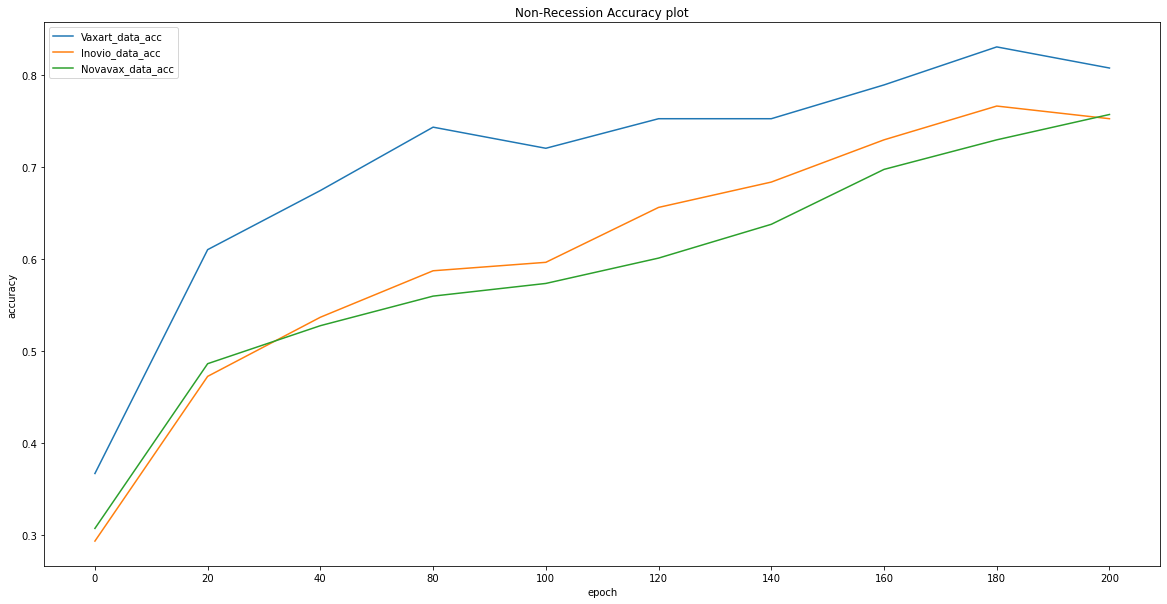

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(Vaxart_data_acc)
plt.plot(Inovio_data_acc)
plt.plot(Novavax_data_acc)

plt.title('Non-Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Vaxart_data_acc','Inovio_data_acc','Novavax_data_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Novavax_data_correct_buys')

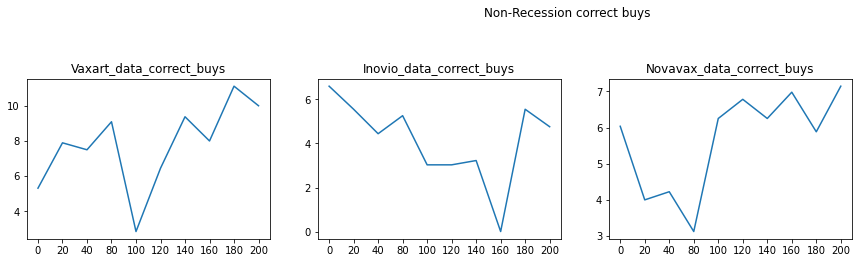

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(Vaxart_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Vaxart_data_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(Inovio_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Inovio_data_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(Novavax_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Novavax_data_correct_buys")

Text(0.5, 1.0, 'Novavax_data_correct_sells')

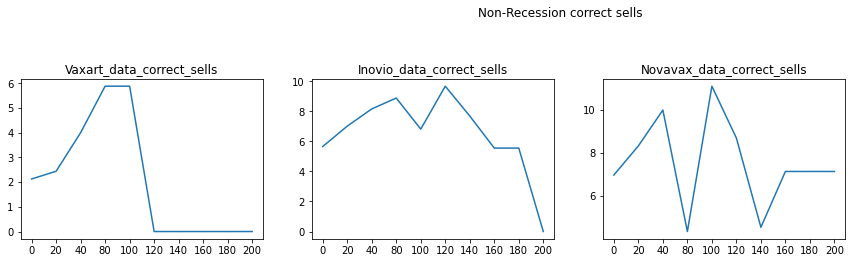

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(Vaxart_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Vaxart_data_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(Inovio_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Inovio_data_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(Novavax_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Novavax_data_correct_sells")

Text(0.5, 1.0, 'Novavax_data_correct_holds')

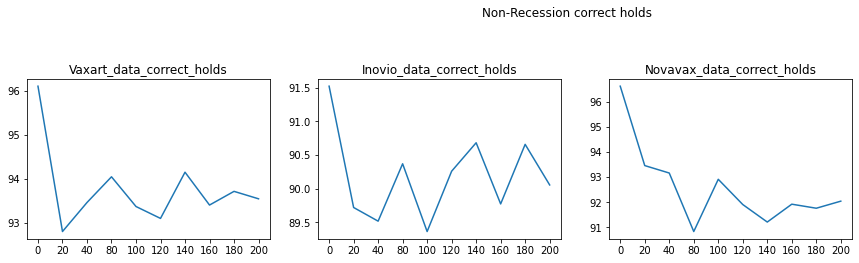

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(Vaxart_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Vaxart_data_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(Inovio_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Inovio_data_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(Novavax_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Novavax_data_correct_holds")

Text(0.5, 1.0, 'Novavax_data_correct_low_buys')

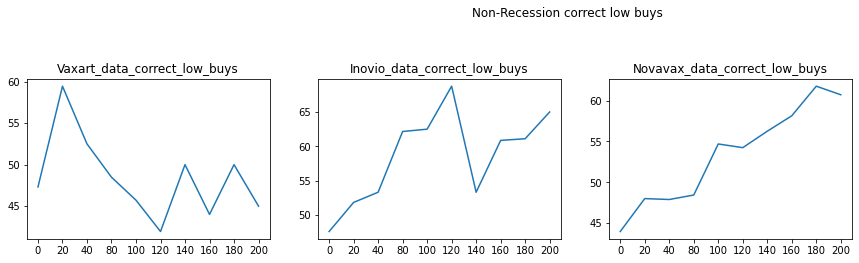

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(Vaxart_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Vaxart_data_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(Inovio_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Inovio_data_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(Novavax_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Novavax_data_correct_low_buys")

Text(0.5, 1.0, 'Novavax_data_correct_high_sells')

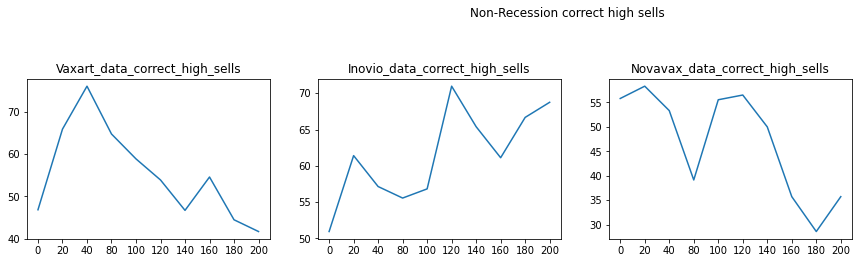

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(Vaxart_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Vaxart_data_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(Inovio_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Inovio_data_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(Novavax_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Novavax_data_correct_high_sells")

Text(0.5, 1.0, 'Novavax_data_correct_mid_holds')

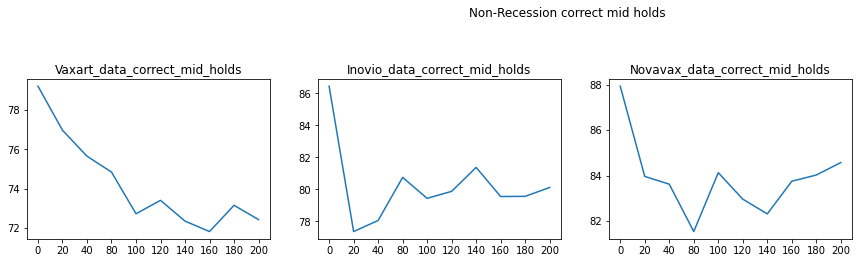

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(Vaxart_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Vaxart_data_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(Inovio_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Inovio_data_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(Novavax_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Novavax_data_correct_mid_holds")

Text(0.5, 1.0, 'Novavax_data_profit')

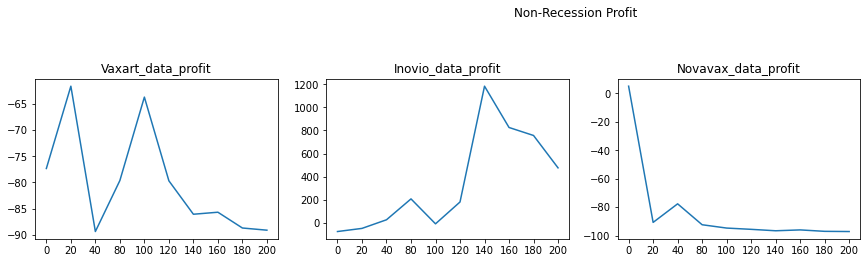

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(Vaxart_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Vaxart_data_profit")

plt.subplot(3, 4, 2)
plt.plot(Inovio_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Inovio_data_profit")

plt.subplot(3, 4, 3)
plt.plot(Novavax_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Novavax_data_profit")

In [26]:
Vaxart_data_acc = []
Inovio_data_acc = []
Novavax_data_acc = []

Vaxart_data_correct_buys = []
Inovio_data_correct_buys = []
Novavax_data_correct_buys = []

Vaxart_data_correct_sells = []
Inovio_data_correct_sells = []
Novavax_data_correct_sells = []

Vaxart_data_correct_holds = []
Inovio_data_correct_holds = []
Novavax_data_correct_holds = []

Vaxart_data_correct_low_buys = []
Inovio_data_correct_low_buys = []
Novavax_data_correct_low_buys = []

Vaxart_data_correct_high_sells = []
Inovio_data_correct_high_sells = []
Novavax_data_correct_high_sells = []

Vaxart_data_correct_mid_holds = []
Inovio_data_correct_mid_holds = []
Novavax_data_correct_mid_holds = []

Vaxart_data_profit = []
Inovio_data_profit = []
Novavax_data_profit = []

for key,value in r_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    Vaxart_data_acc.append(acc[0])
    Inovio_data_acc.append(acc[1])
    Novavax_data_acc.append(acc[2])
    
    Vaxart_data_correct_buys.append(correct_buys[0])
    Inovio_data_correct_buys.append(correct_buys[1]) 
    Novavax_data_correct_buys.append(correct_buys[2]) 

    Vaxart_data_correct_sells.append(correct_sells[0]) 
    Inovio_data_correct_sells.append(correct_sells[1]) 
    Novavax_data_correct_sells.append(correct_sells[2]) 

    Vaxart_data_correct_holds.append(correct_holds[0]) 
    Inovio_data_correct_holds.append(correct_holds[1])  
    Novavax_data_correct_holds.append(correct_holds[2])  

    Vaxart_data_correct_low_buys.append(correct_low_buys[0])  
    Inovio_data_correct_low_buys.append(correct_low_buys[1])  
    Novavax_data_correct_low_buys.append(correct_low_buys[2])  

    Vaxart_data_correct_high_sells.append(correct_high_sells[0]) 
    Inovio_data_correct_high_sells.append(correct_high_sells[1]) 
    Novavax_data_correct_high_sells.append(correct_high_sells[2]) 

    Vaxart_data_correct_mid_holds.append(correct_mid_holds[0])  
    Inovio_data_correct_mid_holds.append(correct_mid_holds[1])  
    Novavax_data_correct_mid_holds.append(correct_mid_holds[2])   

    Vaxart_data_profit.append(profit[0]) 
    Inovio_data_profit.append(profit[1]) 
    Novavax_data_profit.append(profit[2])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


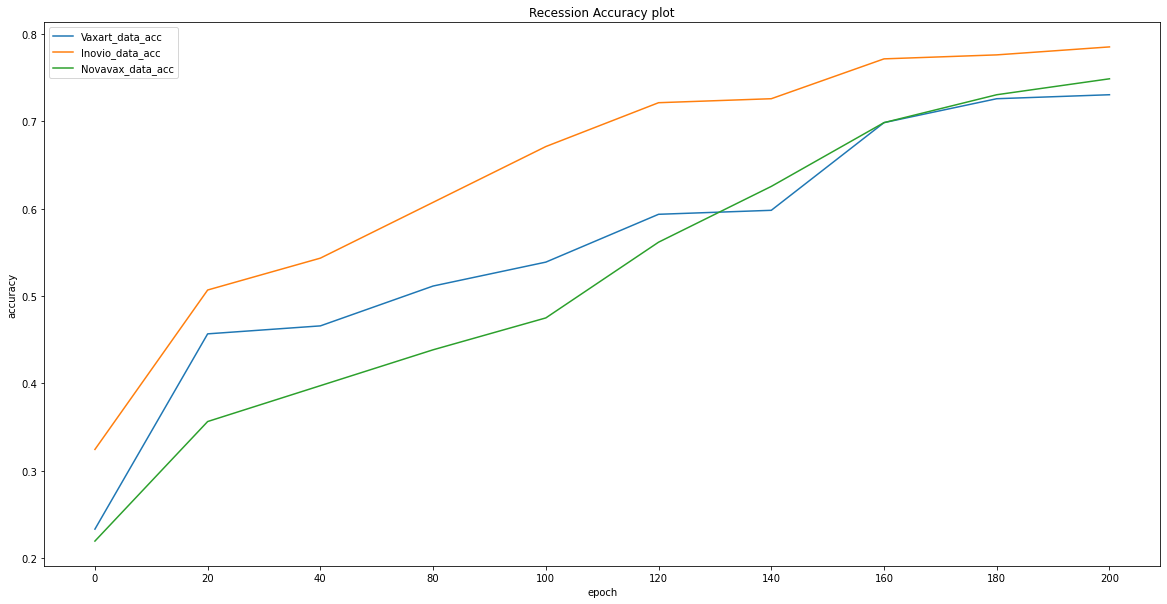

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(Vaxart_data_acc)
plt.plot(Inovio_data_acc)
plt.plot(Novavax_data_acc)

plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Vaxart_data_acc','Inovio_data_acc','Novavax_data_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Novavax_data_correct_buys')

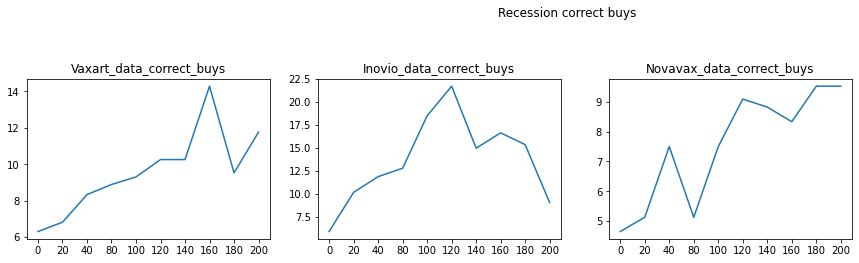

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(Vaxart_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Vaxart_data_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(Inovio_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Inovio_data_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(Novavax_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Novavax_data_correct_buys")

Text(0.5, 1.0, 'Novavax_data_correct_sells')

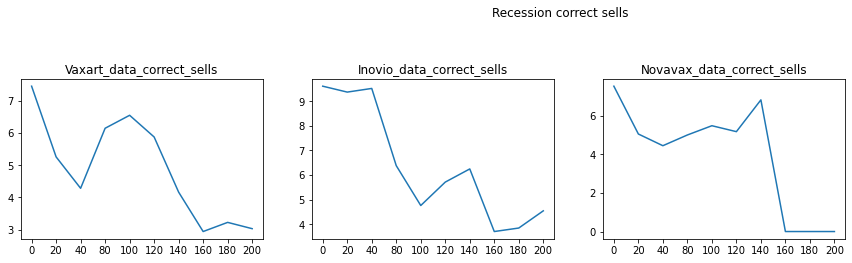

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(Vaxart_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Vaxart_data_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(Inovio_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Inovio_data_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(Novavax_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Novavax_data_correct_sells")

Text(0.5, 1.0, 'Novavax_data_correct_holds')

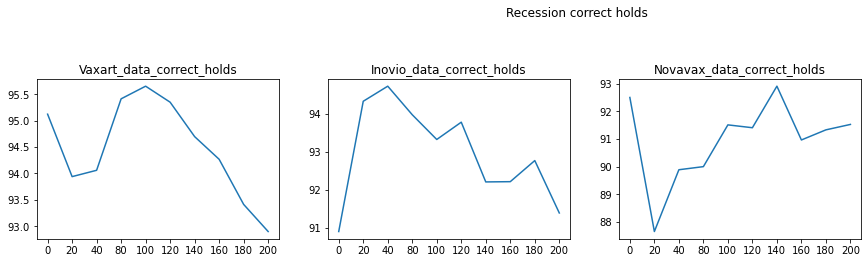

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(Vaxart_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Vaxart_data_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(Inovio_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Inovio_data_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(Novavax_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Novavax_data_correct_holds")

Text(0.5, 1.0, 'Novavax_data_correct_low_buys')

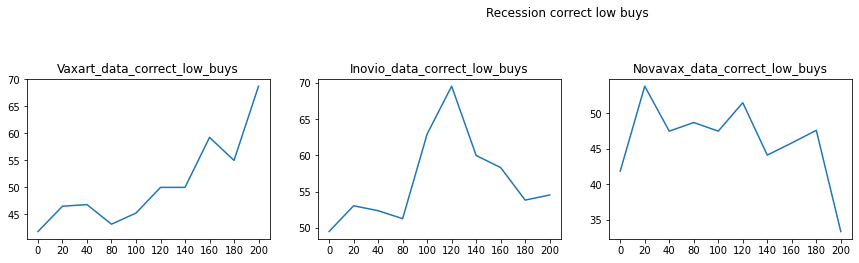

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(Vaxart_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Vaxart_data_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(Inovio_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Inovio_data_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(Novavax_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Novavax_data_correct_low_buys")

Text(0.5, 1.0, 'Novavax_data_correct_high_sells')

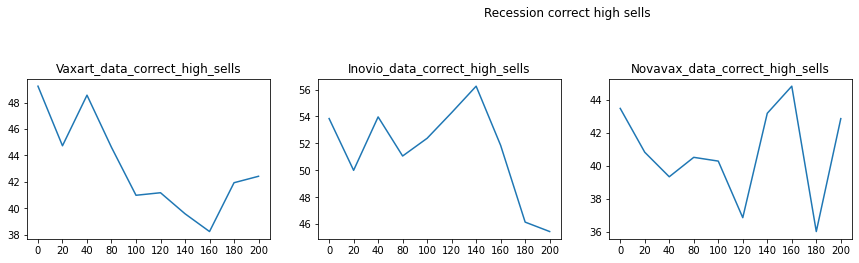

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(Vaxart_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Vaxart_data_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(Inovio_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Inovio_data_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(Novavax_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Novavax_data_correct_high_sells")

Text(0.5, 1.0, 'Novavax_data_correct_mid_holds')

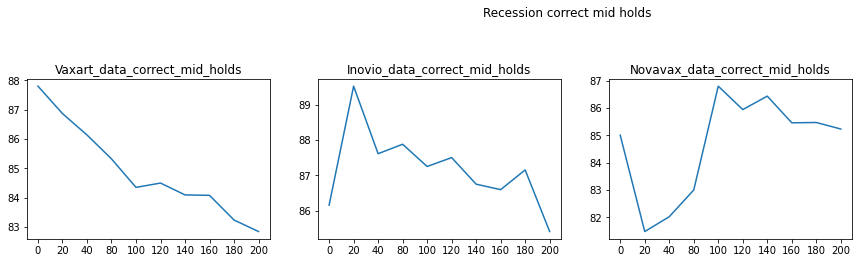

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(Vaxart_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Vaxart_data_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(Inovio_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Inovio_data_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(Novavax_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Novavax_data_correct_mid_holds")

Text(0.5, 1.0, 'Novavax_data_profit')

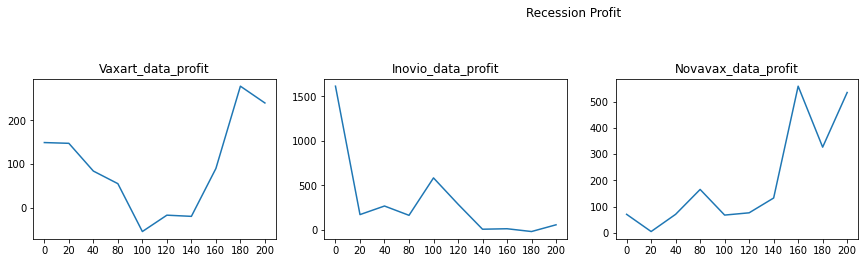

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(Vaxart_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Vaxart_data_profit")

plt.subplot(3, 4, 2)
plt.plot(Inovio_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Inovio_data_profit")

plt.subplot(3, 4, 3)
plt.plot(Novavax_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Novavax_data_profit")

## Train Inovio Pharmaceuticals, Inc. Stock Data

In [35]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

            previous_1d     EMA_12   willr_14    OBV_7  labels
Date                                                          
2000-01-21         51.0  54.535133 -80.952381 -17732.0     2.0
2000-01-24         56.0  54.760497 -57.142857 -10257.0     2.0
2000-01-25         58.0  55.258882 -47.619048  -8463.0     2.0
2000-01-26         59.0  55.834439 -42.857143  -4944.0     2.0
2000-01-27         57.0  56.013756 -52.380952  -5313.0     2.0


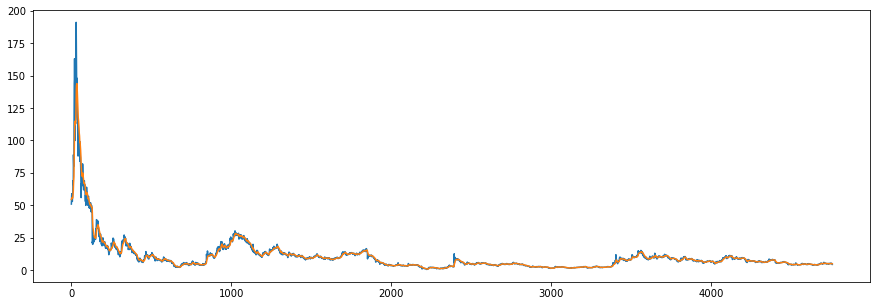

(4745, 15, 4)

In [36]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []

seed = 10
df = pd.read_csv('variation 7/initial_indicators/INO_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
    
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)

X.shape

In [37]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [38]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [39]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [40]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [41]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    nr_log  = pd.DataFrame(columns = column_names)
    r_log  = pd.DataFrame(columns = column_names)
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        callbacks=[tensorboard],
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    test_sets = ['VXRT','INO','NVAX']
    for name in test_sets:
        
        print('\n')
        print("Non-Recession")
        print('\n')
        
        X = nr_test_data['{}_X'.format(name)]
        y = nr_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("variation 7/initial_indicators/{}_data_test.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(nr_log)
        nr_log.loc[df_length] = logger
        print(nr_log.head(20))
        logger = []
        
        print('\n')
        print("Recession")
        print('\n')
        
        X = r_test_data['{}_X'.format(name)]
        y = r_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("variation 7/initial_indicators/{}_data_test2.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(r_log)
        r_log.loc[df_length] = logger
        print(r_log.head(20))
        logger = []

    nr_log.to_csv('{}_{}_{}epochs.csv'.format(experiment,'InovioModel',epochs))
    nr_log_hist['{}_epochs_logs'.format(epochs)] = nr_log
    r_log.to_csv('{}_{}_{}epochs.csv'.format(experiment,'InovioModel',epochs))
    r_log_hist['{}_epochs_logs'.format(epochs)] = r_log
    epochs = epochs + 20

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.443137254901961, 1: 7.3140655105973025, 2: 0.3664446375132735}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 3s 105ms/step - loss: 0.2951 - accuracy: 0.5237 - mse: 0.4354 - weighted_accuracy: 0.3151 - weighted_mse: 0.5222 - val_loss: 0.2994 - val_accuracy: 0.0453 - val_mse: 0.3540 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3540
Epoch 2/20
30/30 [==============================] - 0s 11ms/step - loss: 0.2117 - accuracy: 0.3570 - mse: 0.7499 - weighted_accuracy: 0.4501 - weighted_mse: 0.7368 - val_loss: 0.2906 - val_accuracy: 0.0453 - val_mse: 0.3842 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3842
Epoch 3/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1887 - accuracy: 0.2871 - mse: 1.0175 - weighted_accuracy: 0.4915 - weighted_mse: 0.9804 - val_loss: 0.2791 - val_accuracy: 0.0453 - val_mse: 0.4225 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.4225
Epoch 4/20
30/30 [==============================] - 0

7/7 [==============================] - 0s 3ms/step - loss: 0.1901 - accuracy: 0.3836 - mse: 1.3393 - weighted_accuracy: 0.3836 - weighted_mse: 1.3393
Test loss: 0.19013884663581848
Test accuracy: 0.3835616409778595


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 2
actual holds but predicted buy: 58
actual holds but predicted sell: 69
actual predicted holds: 76
Percentage buys correct: 4.838709677419355%
Percentage sells correct: 6.666666666666667%
Percentage holds correct: 92.6829268292683%
actual buys: 8
actual sells: 8
actual holds: 203


Percentage low buys correct: 51.61290322580645%
Percentage high sells correct: 48.0%
Percentage mid holds correct: 83.95061728395062%


Capital: 100
Share price: $0.012510990752711301
Shares owned at the moment: 7971
Cash capital at the moment: $0.0006486650910915159


Price increase f

7/7 [==============================] - 0s 3ms/step - loss: 0.1823 - accuracy: 0.4201 - mse: 1.2774 - weighted_accuracy: 0.4201 - weighted_mse: 1.2774
Test loss: 0.18234451115131378
Test accuracy: 0.42009133100509644


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold: 5
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 2
actual holds but predicted buy: 53
actual holds but predicted sell: 65
actual predicted holds: 82
Percentage buys correct: 3.5714285714285716%
Percentage sells correct: 10.81081081081081%
Percentage holds correct: 92.13483146067416%
actual buys: 8
actual sells: 11
actual holds: 200


Percentage low buys correct: 50.0%
Percentage high sells correct: 54.054054054054056%
Percentage mid holds correct: 82.95454545454545%


Capital: 100
Share price: $0.02410935049810265
Shares owned at the moment: 4136
Cash capital at the moment: $0.009506587282004375


Price increas

7/7 [==============================] - 0s 3ms/step - loss: 0.1790 - accuracy: 0.4932 - mse: 1.2647 - weighted_accuracy: 0.4932 - weighted_mse: 1.2647
Test loss: 0.17898398637771606
Test accuracy: 0.4931506812572479


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold: 5
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 24
actual holds but predicted sell: 78
actual predicted holds: 99
Percentage buys correct: 7.407407407407407%
Percentage sells correct: 8.13953488372093%
Percentage holds correct: 93.39622641509433%
actual buys: 8
actual sells: 10
actual holds: 201


Percentage low buys correct: 62.96296296296296%
Percentage high sells correct: 47.05882352941177%
Percentage mid holds correct: 86.79245283018868%


Capital: 100
Share price: $0.011748252914169829
Shares owned at the moment: 8488
Cash capital at the moment: $0.006601545003931619


Pri

30/30 [==============================] - 0s 9ms/step - loss: 0.1312 - accuracy: 0.4665 - mse: 1.6837 - weighted_accuracy: 0.7268 - weighted_mse: 1.6435 - val_loss: 0.1900 - val_accuracy: 0.3899 - val_mse: 1.7588 - val_weighted_accuracy: 0.3899 - val_weighted_mse: 1.7588
Epoch 13/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1301 - accuracy: 0.4600 - mse: 1.6916 - weighted_accuracy: 0.7392 - weighted_mse: 1.6523 - val_loss: 0.1898 - val_accuracy: 0.4025 - val_mse: 1.7901 - val_weighted_accuracy: 0.4025 - val_weighted_mse: 1.7901
Epoch 14/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1275 - accuracy: 0.5005 - mse: 1.7116 - weighted_accuracy: 0.7523 - weighted_mse: 1.6934 - val_loss: 0.1893 - val_accuracy: 0.4310 - val_mse: 1.7930 - val_weighted_accuracy: 0.4310 - val_weighted_mse: 1.7930
Epoch 15/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1272 - accuracy: 0.4955 - mse: 1.7391 - weighted_accuracy: 0.7541 - weighted_mse: 1.71

7/7 [==============================] - 0s 4ms/step - loss: 0.1784 - accuracy: 0.4358 - mse: 1.8015 - weighted_accuracy: 0.4358 - weighted_mse: 1.8015
Test loss: 0.1784341037273407
Test accuracy: 0.4357798099517822


number of predictions: 218
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 3
actual holds but predicted buy: 62
actual holds but predicted sell: 52
actual predicted holds: 85
Percentage buys correct: 7.352941176470588%
Percentage sells correct: 8.771929824561404%
Percentage holds correct: 91.39784946236558%
actual buys: 10
actual sells: 9
actual holds: 199


Percentage low buys correct: 47.76119402985075%
Percentage high sells correct: 63.1578947368421%
Percentage mid holds correct: 81.72043010752688%


Capital: 100
Share price: $0.9879411977395466
Shares owned at the moment: 100
Cash capital at the moment: $0.9341963966669624


Price inc

7/7 [==============================] - 0s 5ms/step - loss: 0.1874 - accuracy: 0.4541 - mse: 1.7747 - weighted_accuracy: 0.4541 - weighted_mse: 1.7747
Test loss: 0.1873917430639267
Test accuracy: 0.4541284441947937


number of predictions: 218
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 4
actual sells but predicted hold: 3
actual holds but predicted buy: 79
actual holds but predicted sell: 33
actual predicted holds: 89
Percentage buys correct: 6.976744186046512%
Percentage sells correct: 10.526315789473685%
Percentage holds correct: 94.68085106382979%
actual buys: 9
actual sells: 8
actual holds: 201


Percentage low buys correct: 45.88235294117647%
Percentage high sells correct: 60.526315789473685%
Percentage mid holds correct: 89.36170212765957%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from pr

Epoch 1/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1211 - accuracy: 0.5166 - mse: 1.8699 - weighted_accuracy: 0.7710 - weighted_mse: 1.8662 - val_loss: 0.1845 - val_accuracy: 0.4436 - val_mse: 1.9226 - val_weighted_accuracy: 0.4436 - val_weighted_mse: 1.9226
Epoch 2/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1194 - accuracy: 0.5211 - mse: 1.8607 - weighted_accuracy: 0.7801 - weighted_mse: 1.8584 - val_loss: 0.1868 - val_accuracy: 0.4531 - val_mse: 2.0566 - val_weighted_accuracy: 0.4531 - val_weighted_mse: 2.0566
Epoch 3/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1201 - accuracy: 0.5329 - mse: 1.9114 - weighted_accuracy: 0.7807 - weighted_mse: 1.9193 - val_loss: 0.1820 - val_accuracy: 0.4552 - val_mse: 1.8859 - val_weighted_accuracy: 0.4552 - val_weighted_mse: 1.8859
Epoch 4/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1183 - accuracy: 0.5345 - mse: 1.9131 - weighted_accuracy: 0.7775 - weighted

7/7 [==============================] - 0s 4ms/step - loss: 0.1665 - accuracy: 0.5479 - mse: 2.4536 - weighted_accuracy: 0.5479 - weighted_mse: 2.4536
Test loss: 0.16645757853984833
Test accuracy: 0.5479452013969421


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 6
actual holds but predicted buy: 47
actual holds but predicted sell: 42
actual predicted holds: 114
Percentage buys correct: 7.8431372549019605%
Percentage sells correct: 4.545454545454546%
Percentage holds correct: 91.93548387096774%
actual buys: 8
actual sells: 8
actual holds: 203


Percentage low buys correct: 43.13725490196079%
Percentage high sells correct: 43.18181818181818%
Percentage mid holds correct: 82.11382113821138%


Capital: 100
Share price: $0.01376648238740672
Shares owned at the moment: 7244
Cash capital at the moment: $0.0013594899861857357


P

7/7 [==============================] - 0s 4ms/step - loss: 0.1582 - accuracy: 0.6301 - mse: 2.1669 - weighted_accuracy: 0.6301 - weighted_mse: 2.1669
Test loss: 0.1582382768392563
Test accuracy: 0.6301369667053223


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 39
actual holds but predicted sell: 31
actual predicted holds: 130
Percentage buys correct: 13.043478260869565%
Percentage sells correct: 6.0606060606060606%
Percentage holds correct: 92.85714285714286%
actual buys: 8
actual sells: 11
actual holds: 200


Percentage low buys correct: 52.17391304347826%
Percentage high sells correct: 30.303030303030305%
Percentage mid holds correct: 88.48920863309353%


Capital: 100
Share price: $0.02834215060163773
Shares owned at the moment: 3518
Cash capital at the moment: $0.018118047442911234




7/7 [==============================] - 0s 4ms/step - loss: 0.1784 - accuracy: 0.5890 - mse: 2.5209 - weighted_accuracy: 0.5890 - weighted_mse: 2.5209
Test loss: 0.17842605710029602
Test accuracy: 0.5890411138534546


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 7
actual holds but predicted buy: 36
actual holds but predicted sell: 41
actual predicted holds: 124
Percentage buys correct: 5.2631578947368425%
Percentage sells correct: 6.818181818181818%
Percentage holds correct: 90.51094890510949%
actual buys: 8
actual sells: 10
actual holds: 201


Percentage low buys correct: 57.89473684210526%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 83.08823529411765%


Capital: 100
Share price: $0.023869464968017798
Shares owned at the moment: 4177
Cash capital at the moment: $0.023062251868267936


Price increas

30/30 [==============================] - 0s 12ms/step - loss: 0.0932 - accuracy: 0.6715 - mse: 2.5506 - weighted_accuracy: 0.8610 - weighted_mse: 2.6581 - val_loss: 0.1639 - val_accuracy: 0.6112 - val_mse: 2.8684 - val_weighted_accuracy: 0.6112 - val_weighted_mse: 2.8684
Epoch 12/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0933 - accuracy: 0.6728 - mse: 2.6119 - weighted_accuracy: 0.8525 - weighted_mse: 2.7343 - val_loss: 0.1818 - val_accuracy: 0.5479 - val_mse: 2.7000 - val_weighted_accuracy: 0.5479 - val_weighted_mse: 2.7000
Epoch 13/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0922 - accuracy: 0.6812 - mse: 2.6122 - weighted_accuracy: 0.8703 - weighted_mse: 2.7433 - val_loss: 0.1730 - val_accuracy: 0.5901 - val_mse: 2.9496 - val_weighted_accuracy: 0.5901 - val_weighted_mse: 2.9496
Epoch 14/20
30/30 [==============================] - 0s 12ms/step - loss: 0.0895 - accuracy: 0.7071 - mse: 2.6476 - weighted_accuracy: 0.8723 - weighted_mse: 2.

7/7 [==============================] - 0s 4ms/step - loss: 0.1610 - accuracy: 0.6376 - mse: 2.8212 - weighted_accuracy: 0.6376 - weighted_mse: 2.8212
Test loss: 0.1609574258327484
Test accuracy: 0.6376146674156189


number of predictions: 218
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 6
actual holds but predicted buy: 45
actual holds but predicted sell: 22
actual predicted holds: 132
Percentage buys correct: 8.16326530612245%
Percentage sells correct: 11.538461538461538%
Percentage holds correct: 92.3076923076923%
actual buys: 10
actual sells: 9
actual holds: 199


Percentage low buys correct: 52.083333333333336%
Percentage high sells correct: 65.38461538461539%
Percentage mid holds correct: 81.11888111888112%


Capital: 100
Share price: $0.9879411977395466
Shares owned at the moment: 100
Cash capital at the moment: $0.9341963966669624


Price i

7/7 [==============================] - 0s 3ms/step - loss: 0.1819 - accuracy: 0.6009 - mse: 2.7632 - weighted_accuracy: 0.6009 - weighted_mse: 2.7632
Test loss: 0.18187379837036133
Test accuracy: 0.6009174585342407


number of predictions: 218
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 5
actual holds but predicted buy: 53
actual holds but predicted sell: 24
actual predicted holds: 124
Percentage buys correct: 7.017543859649122%
Percentage sells correct: 10.714285714285714%
Percentage holds correct: 93.23308270676692%
actual buys: 9
actual sells: 8
actual holds: 201


Percentage low buys correct: 42.857142857142854%
Percentage high sells correct: 67.85714285714286%
Percentage mid holds correct: 84.9624060150376%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from p

Epoch 1/20
30/30 [==============================] - 0s 16ms/step - loss: 0.0847 - accuracy: 0.7071 - mse: 2.9265 - weighted_accuracy: 0.8797 - weighted_mse: 3.0833 - val_loss: 0.1636 - val_accuracy: 0.6196 - val_mse: 2.9985 - val_weighted_accuracy: 0.6196 - val_weighted_mse: 2.9985
Epoch 2/20
30/30 [==============================] - 0s 11ms/step - loss: 0.0844 - accuracy: 0.7115 - mse: 2.8733 - weighted_accuracy: 0.8758 - weighted_mse: 3.0337 - val_loss: 0.1821 - val_accuracy: 0.5848 - val_mse: 3.1504 - val_weighted_accuracy: 0.5848 - val_weighted_mse: 3.1504
Epoch 3/20
30/30 [==============================] - 0s 11ms/step - loss: 0.0854 - accuracy: 0.7123 - mse: 2.9595 - weighted_accuracy: 0.8705 - weighted_mse: 3.1058 - val_loss: 0.1757 - val_accuracy: 0.5911 - val_mse: 3.1211 - val_weighted_accuracy: 0.5911 - val_weighted_mse: 3.1211
Epoch 4/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0830 - accuracy: 0.7281 - mse: 2.9689 - weighted_accuracy: 0.8874 - weighted

0         -97.406542  


Recession


7/7 [==============================] - 0s 5ms/step - loss: 0.1470 - accuracy: 0.6438 - mse: 4.1545 - weighted_accuracy: 0.6438 - weighted_mse: 4.1545
Test loss: 0.1470111906528473
Test accuracy: 0.6438356041908264


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 5
actual holds but predicted buy: 32
actual holds but predicted sell: 35
actual predicted holds: 136
Percentage buys correct: 5.882352941176471%
Percentage sells correct: 7.894736842105263%
Percentage holds correct: 92.51700680272108%
actual buys: 8
actual sells: 8
actual holds: 203


Percentage low buys correct: 35.294117647058826%
Percentage high sells correct: 47.36842105263158%
Percentage mid holds correct: 82.87671232876713%


Capital: 100
Share price: $0.05017576972685583
Shares owned at the moment: 1987
Cash capital at th

Test loss: 0.15260039269924164
Test accuracy: 0.7442922592163086


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 18
actual holds but predicted sell: 22
actual predicted holds: 160
Percentage buys correct: 9.523809523809524%
Percentage sells correct: 4.3478260869565215%
Percentage holds correct: 91.42857142857143%
actual buys: 8
actual sells: 11
actual holds: 200


Percentage low buys correct: 60.0%
Percentage high sells correct: 26.08695652173913%
Percentage mid holds correct: 86.28571428571429%


Capital: 100
Share price: $0.02834215060163773
Shares owned at the moment: 3518
Cash capital at the moment: $0.018118047442911234


Price increase from previously bought: 35.71889561556665%
Share price: $0.03857143433816657
Shares owned at the moment: 0
Cash capital at the moment: $135.339264707




RUNNING EPOCHS 100 - 120



Epoch 1/20
30/30 [==============================] - 0s 16ms/step - loss: 0.0692 - accuracy: 0.7819 - mse: 3.6958 - weighted_accuracy: 0.9127 - weighted_mse: 3.8915 - val_loss: 0.1641 - val_accuracy: 0.6617 - val_mse: 3.7411 - val_weighted_accuracy: 0.6617 - val_weighted_mse: 3.7411
Epoch 2/20
30/30 [==============================] - 0s 11ms/step - loss: 0.0688 - accuracy: 0.7792 - mse: 3.6680 - weighted_accuracy: 0.9135 - weighted_mse: 3.8589 - val_loss: 0.1658 - val_accuracy: 0.6870 - val_mse: 4.1966 - val_weighted_accuracy: 0.6870 - val_weighted_mse: 4.1966
Epoch 3/20
30/30 [==============================] - 0s 12ms/step - loss: 0.0704 - accuracy: 0.7837 - mse: 3.7858 - weighted_accuracy: 0.9096 - weighted_mse: 3.9603 - val_loss: 0.1665 - val_accuracy: 0.6670 - val_mse: 3.9876 - val_weighted_accuracy: 0.6670 - val_weighted_mse: 3.9876
Epoch 4/20
30/30 [==============================] - 0s 11ms/step - loss: 0.0678 - accuracy: 0.7940 - mse: 3.7989 - weigh

7/7 [==============================] - 0s 5ms/step - loss: 0.1393 - accuracy: 0.7260 - mse: 5.3010 - weighted_accuracy: 0.7260 - weighted_mse: 5.3010
Test loss: 0.13930708169937134
Test accuracy: 0.7260273694992065


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 6
actual holds but predicted buy: 19
actual holds but predicted sell: 30
actual predicted holds: 154
Percentage buys correct: 13.636363636363637%
Percentage sells correct: 6.25%
Percentage holds correct: 93.33333333333333%
actual buys: 8
actual sells: 8
actual holds: 203


Percentage low buys correct: 40.90909090909091%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 84.14634146341463%


Capital: 100
Share price: $0.05394225211426253
Shares owned at the moment: 1848
Cash capital at the moment: $0.04058356759814785


Price increase from previousl

7/7 [==============================] - 0s 4ms/step - loss: 0.1660 - accuracy: 0.7018 - mse: 4.5432 - weighted_accuracy: 0.7018 - weighted_mse: 4.5432
Test loss: 0.16598181426525116
Test accuracy: 0.7018348574638367


number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 1
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 6
actual holds but predicted buy: 34
actual holds but predicted sell: 17
actual predicted holds: 150
Percentage buys correct: 2.857142857142857%
Percentage sells correct: 10.0%
Percentage holds correct: 92.02453987730061%
actual buys: 9
actual sells: 8
actual holds: 201


Percentage low buys correct: 38.23529411764706%
Percentage high sells correct: 65.0%
Percentage mid holds correct: 84.66257668711657%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from previously bought: -77.18778

30/30 [==============================] - 0s 10ms/step - loss: 0.0532 - accuracy: 0.8417 - mse: 4.9158 - weighted_accuracy: 0.9383 - weighted_mse: 5.0246 - val_loss: 0.1808 - val_accuracy: 0.7081 - val_mse: 5.6900 - val_weighted_accuracy: 0.7081 - val_weighted_mse: 5.6900
Epoch 7/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0508 - accuracy: 0.8654 - mse: 5.0433 - weighted_accuracy: 0.9470 - weighted_mse: 5.1188 - val_loss: 0.1752 - val_accuracy: 0.7229 - val_mse: 5.2989 - val_weighted_accuracy: 0.7229 - val_weighted_mse: 5.2989
Epoch 8/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0534 - accuracy: 0.8435 - mse: 5.0711 - weighted_accuracy: 0.9390 - weighted_mse: 5.1792 - val_loss: 0.2019 - val_accuracy: 0.6723 - val_mse: 5.6143 - val_weighted_accuracy: 0.6723 - val_weighted_mse: 5.6143
Epoch 9/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0513 - accuracy: 0.8496 - mse: 5.1032 - weighted_accuracy: 0.9430 - weighted_mse: 5.190

7/7 [==============================] - 0s 3ms/step - loss: 0.1289 - accuracy: 0.8440 - mse: 5.5617 - weighted_accuracy: 0.8440 - weighted_mse: 5.5617
Test loss: 0.12888887524604797
Test accuracy: 0.8440366983413696


number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 7
actual holds but predicted buy: 8
actual holds but predicted sell: 10
actual predicted holds: 181
Percentage buys correct: 11.11111111111111%
Percentage sells correct: 16.666666666666668%
Percentage holds correct: 91.87817258883248%
actual buys: 10
actual sells: 9
actual holds: 199


Percentage low buys correct: 44.44444444444444%
Percentage high sells correct: 66.66666666666667%
Percentage mid holds correct: 81.12244897959184%


Capital: 100
Share price: $0.9879411977395466
Shares owned at the moment: 100
Cash capital at the moment: $0.9341963966669624


Price 

7/7 [==============================] - 0s 4ms/step - loss: 0.1885 - accuracy: 0.7626 - mse: 6.4641 - weighted_accuracy: 0.7626 - weighted_mse: 6.4641
Test loss: 0.18845978379249573
Test accuracy: 0.7625570893287659


number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 8
actual holds but predicted buy: 13
actual holds but predicted sell: 23
actual predicted holds: 165
Percentage buys correct: 6.666666666666667%
Percentage sells correct: 4.166666666666667%
Percentage holds correct: 91.66666666666667%
actual buys: 8
actual sells: 10
actual holds: 201


Percentage low buys correct: 53.333333333333336%
Percentage high sells correct: 37.5%
Percentage mid holds correct: 84.35754189944134%


Capital: 100
Share price: $0.23803031635156474
Shares owned at the moment: 418
Cash capital at the moment: $0.2297119163998076


Price increase fr

30/30 [==============================] - 0s 14ms/step - loss: 0.0388 - accuracy: 0.8870 - mse: 7.2032 - weighted_accuracy: 0.9531 - weighted_mse: 7.0154 - val_loss: 0.1990 - val_accuracy: 0.7513 - val_mse: 7.9902 - val_weighted_accuracy: 0.7513 - val_weighted_mse: 7.9902
Epoch 20/20
30/30 [==============================] - 0s 12ms/step - loss: 0.0377 - accuracy: 0.8959 - mse: 7.1648 - weighted_accuracy: 0.9600 - weighted_mse: 7.0128 - val_loss: 0.1987 - val_accuracy: 0.7566 - val_mse: 8.2221 - val_weighted_accuracy: 0.7566 - val_weighted_mse: 8.2221
Validation loss: 0.19868144392967224
Validation accuracy: 0.7565858960151672


Non-Recession


7/7 [==============================] - 0s 4ms/step - loss: 0.1723 - accuracy: 0.7752 - mse: 7.7768 - weighted_accuracy: 0.7752 - weighted_mse: 7.7768
Test loss: 0.1722952425479889
Test accuracy: 0.7752293348312378


number of predictions: 218
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells 

7/7 [==============================] - 0s 4ms/step - loss: 0.1772 - accuracy: 0.8311 - mse: 8.2335 - weighted_accuracy: 0.8311 - weighted_mse: 8.2335
Test loss: 0.17724750936031342
Test accuracy: 0.8310502171516418


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 10
actual holds but predicted sell: 11
actual predicted holds: 179
Percentage buys correct: 15.384615384615385%
Percentage sells correct: 8.333333333333334%
Percentage holds correct: 92.26804123711341%
actual buys: 8
actual sells: 11
actual holds: 200


Percentage low buys correct: 66.66666666666667%
Percentage high sells correct: 16.666666666666668%
Percentage mid holds correct: 87.11340206185567%


Capital: 100
Share price: $0.02834215060163773
Shares owned at the moment: 3518
Cash capital at the moment: $0.018118047442911234




Epoch 1/20
30/30 [==============================] - 1s 20ms/step - loss: 0.0364 - accuracy: 0.9038 - mse: 7.4090 - weighted_accuracy: 0.9629 - weighted_mse: 7.2034 - val_loss: 0.2013 - val_accuracy: 0.7450 - val_mse: 7.2995 - val_weighted_accuracy: 0.7450 - val_weighted_mse: 7.2995
Epoch 2/20
30/30 [==============================] - 0s 12ms/step - loss: 0.0362 - accuracy: 0.8962 - mse: 7.3262 - weighted_accuracy: 0.9620 - weighted_mse: 7.1174 - val_loss: 0.1971 - val_accuracy: 0.7956 - val_mse: 8.9902 - val_weighted_accuracy: 0.7956 - val_weighted_mse: 8.9902
Epoch 3/20
30/30 [==============================] - 0s 12ms/step - loss: 0.0382 - accuracy: 0.9002 - mse: 7.4947 - weighted_accuracy: 0.9560 - weighted_mse: 7.2116 - val_loss: 0.1942 - val_accuracy: 0.7608 - val_mse: 8.0989 - val_weighted_accuracy: 0.7608 - val_weighted_mse: 8.0989
Epoch 4/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0359 - accuracy: 0.9023 - mse: 7.4817 - weighted_accuracy: 0.9623 - weighted

7/7 [==============================] - 0s 4ms/step - loss: 0.1598 - accuracy: 0.7808 - mse: 9.9401 - weighted_accuracy: 0.7808 - weighted_mse: 9.9401
Test loss: 0.1597905158996582
Test accuracy: 0.7808219194412231


number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 7
actual holds but predicted buy: 13
actual holds but predicted sell: 21
actual predicted holds: 169
Percentage buys correct: 7.142857142857143%
Percentage sells correct: 4.545454545454546%
Percentage holds correct: 92.34972677595628%
actual buys: 8
actual sells: 8
actual holds: 203


Percentage low buys correct: 35.714285714285715%
Percentage high sells correct: 54.54545454545455%
Percentage mid holds correct: 84.06593406593407%


Capital: 100
Share price: $0.11483365626355417
Shares owned at the moment: 868
Cash capital at the moment: $0.05027842573387886


Price

7/7 [==============================] - 0s 5ms/step - loss: 0.1958 - accuracy: 0.7661 - mse: 8.8946 - weighted_accuracy: 0.7661 - weighted_mse: 8.8946
Test loss: 0.19575920701026917
Test accuracy: 0.7660550475120544


number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 1
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 7
actual holds but predicted buy: 23
actual holds but predicted sell: 13
actual predicted holds: 165
Percentage buys correct: 4.166666666666667%
Percentage sells correct: 6.666666666666667%
Percentage holds correct: 92.17877094972067%
actual buys: 9
actual sells: 8
actual holds: 201


Percentage low buys correct: 33.333333333333336%
Percentage high sells correct: 60.0%
Percentage mid holds correct: 83.70786516853933%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from previously bou

30/30 [==============================] - 0s 12ms/step - loss: 0.0277 - accuracy: 0.9318 - mse: 9.4066 - weighted_accuracy: 0.9750 - weighted_mse: 8.7205 - val_loss: 0.2507 - val_accuracy: 0.7260 - val_mse: 10.1305 - val_weighted_accuracy: 0.7260 - val_weighted_mse: 10.1305
Epoch 7/20
30/30 [==============================] - 0s 12ms/step - loss: 0.0268 - accuracy: 0.9428 - mse: 9.6599 - weighted_accuracy: 0.9791 - weighted_mse: 8.8902 - val_loss: 0.2422 - val_accuracy: 0.7650 - val_mse: 10.0058 - val_weighted_accuracy: 0.7650 - val_weighted_mse: 10.0058
Epoch 8/20
30/30 [==============================] - 0s 11ms/step - loss: 0.0283 - accuracy: 0.9310 - mse: 9.5165 - weighted_accuracy: 0.9747 - weighted_mse: 8.9381 - val_loss: 0.2417 - val_accuracy: 0.7566 - val_mse: 10.3259 - val_weighted_accuracy: 0.7566 - val_weighted_mse: 10.3259
Epoch 9/20
30/30 [==============================] - 0s 12ms/step - loss: 0.0266 - accuracy: 0.9336 - mse: 9.5899 - weighted_accuracy: 0.9757 - weighted_mse:

7/7 [==============================] - 0s 3ms/step - loss: 0.1565 - accuracy: 0.8578 - mse: 10.3338 - weighted_accuracy: 0.8578 - weighted_mse: 10.3338
Test loss: 0.1565379947423935
Test accuracy: 0.857798159122467


number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 9
actual holds but predicted buy: 7
actual holds but predicted sell: 6
actual predicted holds: 186
Percentage buys correct: 12.5%
Percentage sells correct: 0.0%
Percentage holds correct: 91.17647058823529%
actual buys: 10
actual sells: 9
actual holds: 199


Percentage low buys correct: 62.5%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 80.29556650246306%


Capital: 100
Share price: $0.6570588132171898
Shares owned at the moment: 151
Cash capital at the moment: $0.5112755320158868


Price increase from previously bought: 8.653758490184703%
Sha

7/7 [==============================] - 0s 4ms/step - loss: 0.2288 - accuracy: 0.7900 - mse: 11.0341 - weighted_accuracy: 0.7900 - weighted_mse: 11.0341
Test loss: 0.22876183688640594
Test accuracy: 0.7899543642997742


number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 1
actual predicted sells: 0
actual sells but predicted hold: 9
actual holds but predicted buy: 14
actual holds but predicted sell: 15
actual predicted holds: 172
Percentage buys correct: 6.25%
Percentage sells correct: 0.0%
Percentage holds correct: 91.48936170212765%
actual buys: 8
actual sells: 10
actual holds: 201


Percentage low buys correct: 62.5%
Percentage high sells correct: 33.333333333333336%
Percentage mid holds correct: 84.49197860962566%


Capital: 100
Share price: $0.023869464968017798
Shares owned at the moment: 4177
Cash capital at the moment: $0.023062251868267936


Price increase from previously bought:

In [42]:
Vaxart_data_acc = []
Inovio_data_acc = []
Novavax_data_acc = []

Vaxart_data_correct_buys = []
Inovio_data_correct_buys = []
Novavax_data_correct_buys = []

Vaxart_data_correct_sells = []
Inovio_data_correct_sells = []
Novavax_data_correct_sells = []

Vaxart_data_correct_holds = []
Inovio_data_correct_holds = []
Novavax_data_correct_holds = []

Vaxart_data_correct_low_buys = []
Inovio_data_correct_low_buys = []
Novavax_data_correct_low_buys = []

Vaxart_data_correct_high_sells = []
Inovio_data_correct_high_sells = []
Novavax_data_correct_high_sells = []

Vaxart_data_correct_mid_holds = []
Inovio_data_correct_mid_holds = []
Novavax_data_correct_mid_holds = []

Vaxart_data_profit = []
Inovio_data_profit = []
Novavax_data_profit = []

for key,value in nr_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    Vaxart_data_acc.append(acc[0])
    Inovio_data_acc.append(acc[1])
    Novavax_data_acc.append(acc[2])
    
    Vaxart_data_correct_buys.append(correct_buys[0])
    Inovio_data_correct_buys.append(correct_buys[1]) 
    Novavax_data_correct_buys.append(correct_buys[2]) 

    Vaxart_data_correct_sells.append(correct_sells[0]) 
    Inovio_data_correct_sells.append(correct_sells[1]) 
    Novavax_data_correct_sells.append(correct_sells[2]) 

    Vaxart_data_correct_holds.append(correct_holds[0]) 
    Inovio_data_correct_holds.append(correct_holds[1])  
    Novavax_data_correct_holds.append(correct_holds[2])  

    Vaxart_data_correct_low_buys.append(correct_low_buys[0])  
    Inovio_data_correct_low_buys.append(correct_low_buys[1])  
    Novavax_data_correct_low_buys.append(correct_low_buys[2])  

    Vaxart_data_correct_high_sells.append(correct_high_sells[0]) 
    Inovio_data_correct_high_sells.append(correct_high_sells[1]) 
    Novavax_data_correct_high_sells.append(correct_high_sells[2]) 

    Vaxart_data_correct_mid_holds.append(correct_mid_holds[0])  
    Inovio_data_correct_mid_holds.append(correct_mid_holds[1])  
    Novavax_data_correct_mid_holds.append(correct_mid_holds[2])   

    Vaxart_data_profit.append(profit[0]) 
    Inovio_data_profit.append(profit[1]) 
    Novavax_data_profit.append(profit[2])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


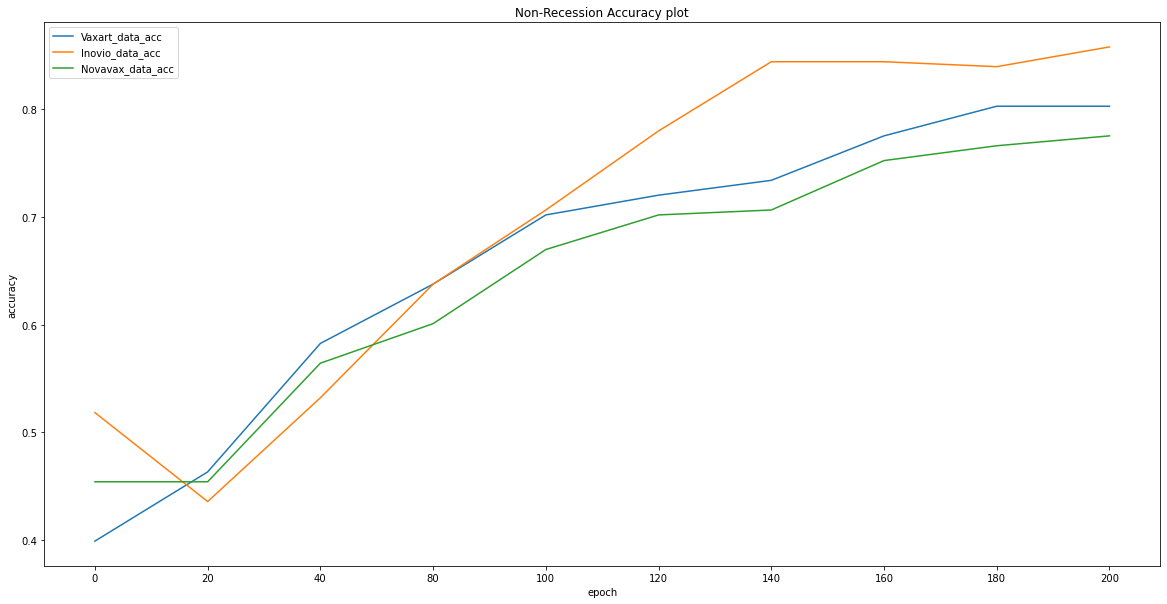

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(Vaxart_data_acc)
plt.plot(Inovio_data_acc)
plt.plot(Novavax_data_acc)

plt.title('Non-Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Vaxart_data_acc','Inovio_data_acc','Novavax_data_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Novavax_data_correct_buys')

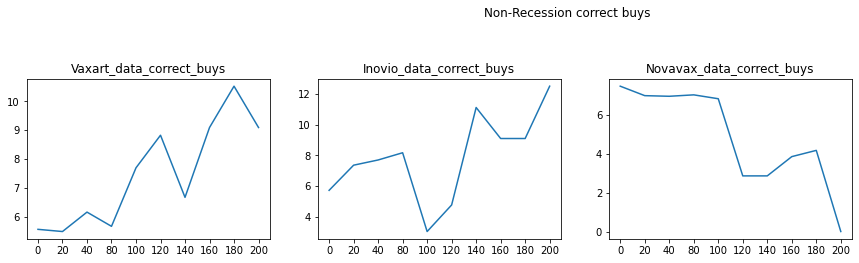

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(Vaxart_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Vaxart_data_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(Inovio_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Inovio_data_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(Novavax_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Novavax_data_correct_buys")

Text(0.5, 1.0, 'Novavax_data_correct_sells')

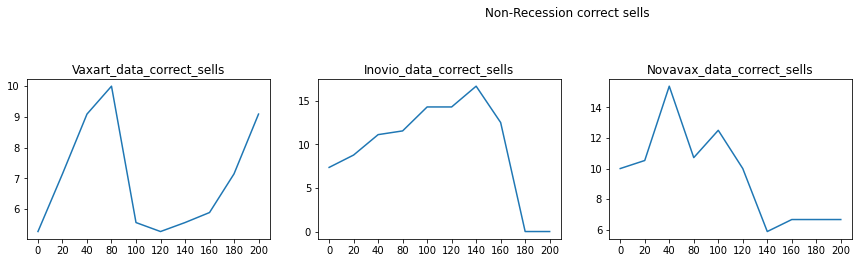

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(Vaxart_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Vaxart_data_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(Inovio_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Inovio_data_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(Novavax_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Novavax_data_correct_sells")

Text(0.5, 1.0, 'Novavax_data_correct_holds')

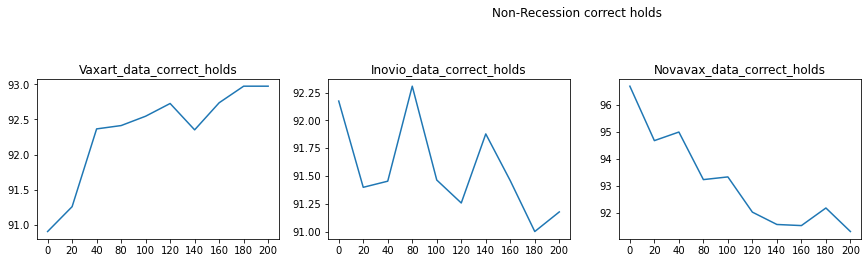

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(Vaxart_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Vaxart_data_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(Inovio_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Inovio_data_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(Novavax_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Novavax_data_correct_holds")

Text(0.5, 1.0, 'Novavax_data_correct_low_buys')

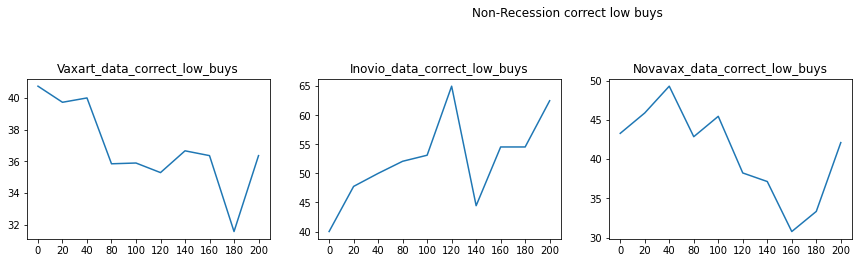

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(Vaxart_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Vaxart_data_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(Inovio_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Inovio_data_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(Novavax_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Novavax_data_correct_low_buys")

Text(0.5, 1.0, 'Novavax_data_correct_high_sells')

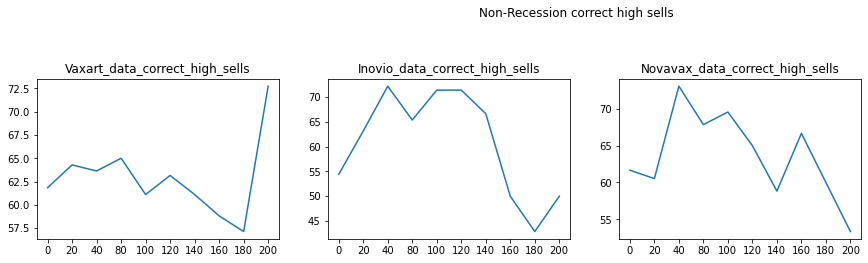

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(Vaxart_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Vaxart_data_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(Inovio_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Inovio_data_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(Novavax_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Novavax_data_correct_high_sells")

Text(0.5, 1.0, 'Novavax_data_correct_mid_holds')

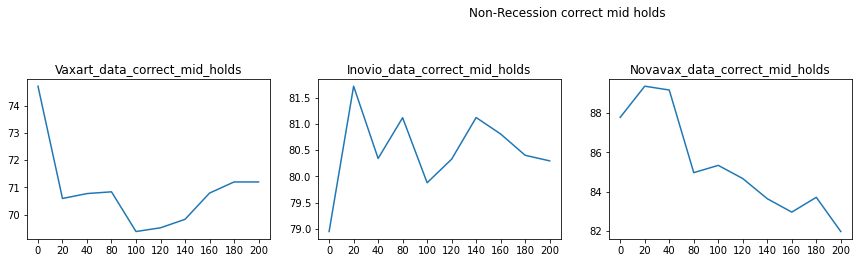

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(Vaxart_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Vaxart_data_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(Inovio_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Inovio_data_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(Novavax_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Novavax_data_correct_mid_holds")

Text(0.5, 1.0, 'Novavax_data_profit')

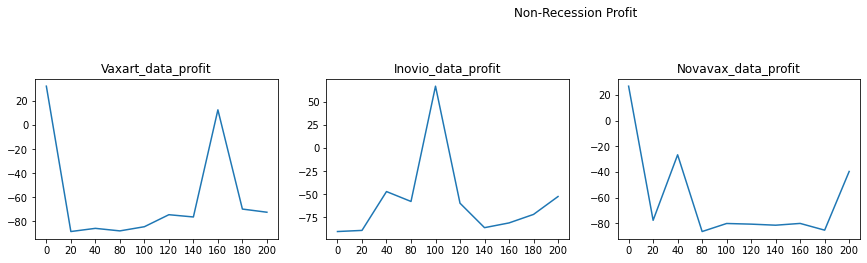

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(Vaxart_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Vaxart_data_profit")

plt.subplot(3, 4, 2)
plt.plot(Inovio_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Inovio_data_profit")

plt.subplot(3, 4, 3)
plt.plot(Novavax_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Novavax_data_profit")

In [51]:
Vaxart_data_acc = []
Inovio_data_acc = []
Novavax_data_acc = []

Vaxart_data_correct_buys = []
Inovio_data_correct_buys = []
Novavax_data_correct_buys = []

Vaxart_data_correct_sells = []
Inovio_data_correct_sells = []
Novavax_data_correct_sells = []

Vaxart_data_correct_holds = []
Inovio_data_correct_holds = []
Novavax_data_correct_holds = []

Vaxart_data_correct_low_buys = []
Inovio_data_correct_low_buys = []
Novavax_data_correct_low_buys = []

Vaxart_data_correct_high_sells = []
Inovio_data_correct_high_sells = []
Novavax_data_correct_high_sells = []

Vaxart_data_correct_mid_holds = []
Inovio_data_correct_mid_holds = []
Novavax_data_correct_mid_holds = []

Vaxart_data_profit = []
Inovio_data_profit = []
Novavax_data_profit = []

for key,value in r_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    Vaxart_data_acc.append(acc[0])
    Inovio_data_acc.append(acc[1])
    Novavax_data_acc.append(acc[2])
    
    Vaxart_data_correct_buys.append(correct_buys[0])
    Inovio_data_correct_buys.append(correct_buys[1]) 
    Novavax_data_correct_buys.append(correct_buys[2]) 

    Vaxart_data_correct_sells.append(correct_sells[0]) 
    Inovio_data_correct_sells.append(correct_sells[1]) 
    Novavax_data_correct_sells.append(correct_sells[2]) 

    Vaxart_data_correct_holds.append(correct_holds[0]) 
    Inovio_data_correct_holds.append(correct_holds[1])  
    Novavax_data_correct_holds.append(correct_holds[2])  

    Vaxart_data_correct_low_buys.append(correct_low_buys[0])  
    Inovio_data_correct_low_buys.append(correct_low_buys[1])  
    Novavax_data_correct_low_buys.append(correct_low_buys[2])  

    Vaxart_data_correct_high_sells.append(correct_high_sells[0]) 
    Inovio_data_correct_high_sells.append(correct_high_sells[1]) 
    Novavax_data_correct_high_sells.append(correct_high_sells[2]) 

    Vaxart_data_correct_mid_holds.append(correct_mid_holds[0])  
    Inovio_data_correct_mid_holds.append(correct_mid_holds[1])  
    Novavax_data_correct_mid_holds.append(correct_mid_holds[2])   

    Vaxart_data_profit.append(profit[0]) 
    Inovio_data_profit.append(profit[1]) 
    Novavax_data_profit.append(profit[2])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


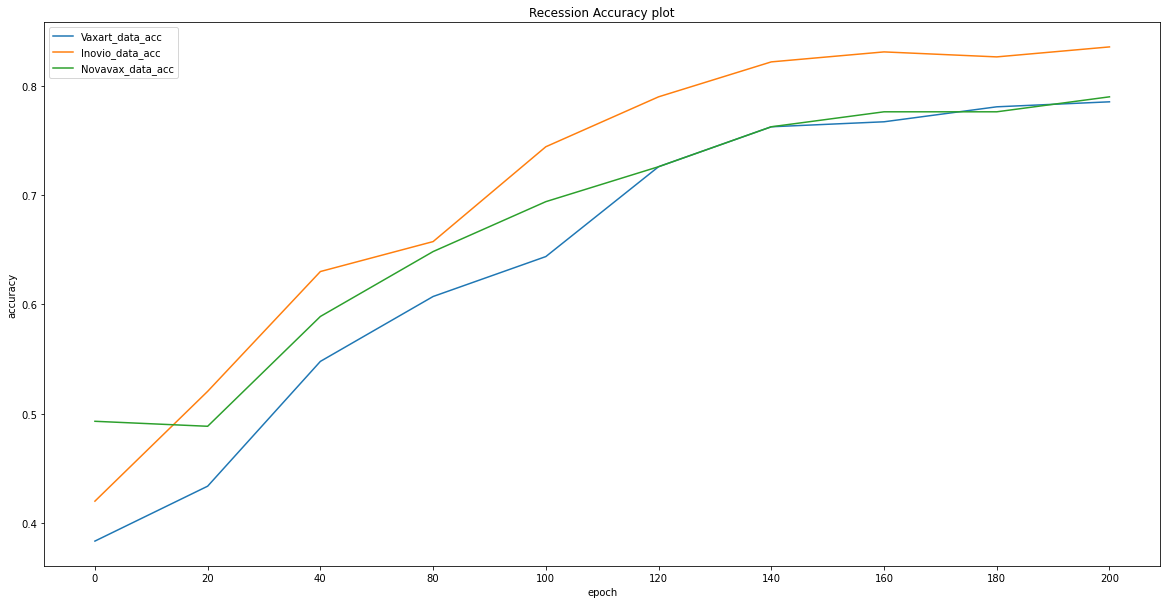

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(Vaxart_data_acc)
plt.plot(Inovio_data_acc)
plt.plot(Novavax_data_acc)

plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Vaxart_data_acc','Inovio_data_acc','Novavax_data_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Novavax_data_correct_buys')

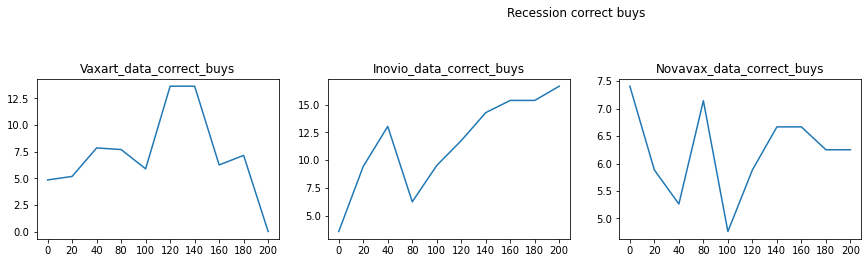

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(Vaxart_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Vaxart_data_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(Inovio_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Inovio_data_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(Novavax_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Novavax_data_correct_buys")

Text(0.5, 1.0, 'Novavax_data_correct_sells')

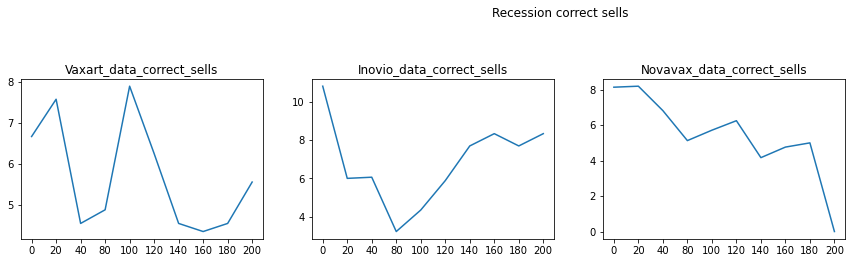

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(Vaxart_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Vaxart_data_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(Inovio_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Inovio_data_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(Novavax_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Novavax_data_correct_sells")

Text(0.5, 1.0, 'Novavax_data_correct_low_buys')

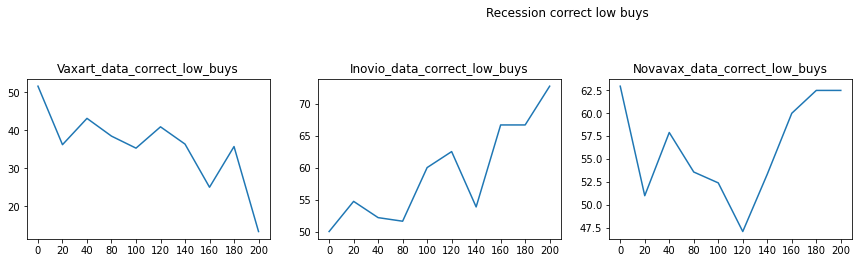

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(Vaxart_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Vaxart_data_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(Inovio_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Inovio_data_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(Novavax_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Novavax_data_correct_low_buys")

Text(0.5, 1.0, 'Novavax_data_correct_high_sells')

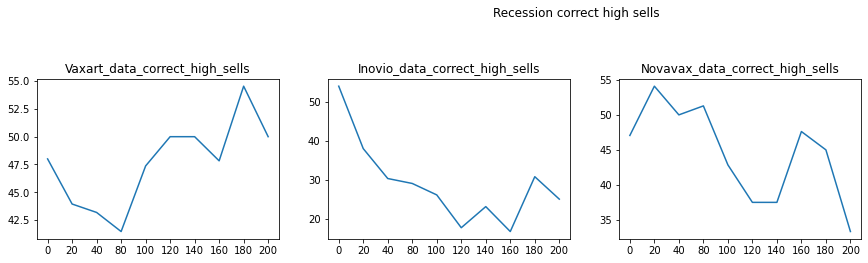

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(Vaxart_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Vaxart_data_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(Inovio_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Inovio_data_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(Novavax_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Novavax_data_correct_high_sells")

Text(0.5, 1.0, 'Novavax_data_correct_mid_holds')

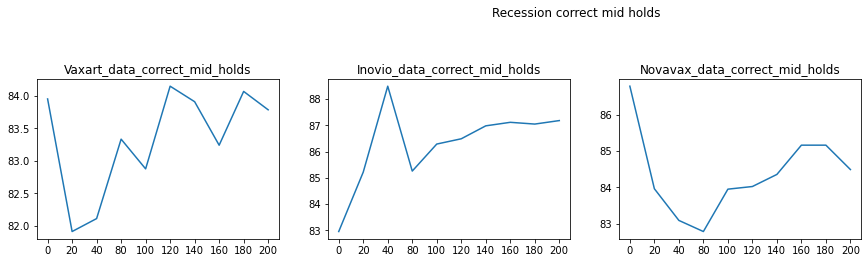

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(Vaxart_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Vaxart_data_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(Inovio_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Inovio_data_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(Novavax_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Novavax_data_correct_mid_holds")

Text(0.5, 1.0, 'Novavax_data_profit')

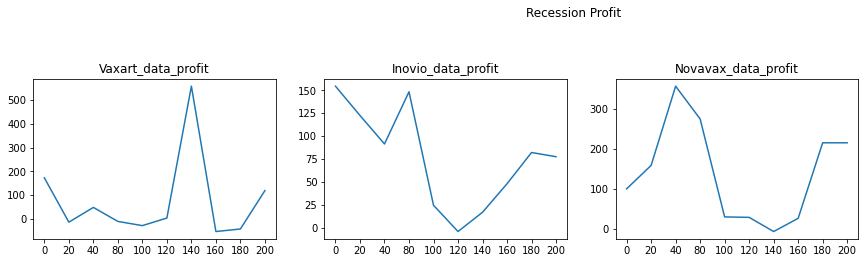

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(Vaxart_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Vaxart_data_profit")

plt.subplot(3, 4, 2)
plt.plot(Inovio_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Inovio_data_profit")

plt.subplot(3, 4, 3)
plt.plot(Novavax_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Novavax_data_profit")

## Train Novavax, Inc Stock Data

In [59]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

            previous_1d      EMA_12   willr_14    OBV_7  labels
Date                                                           
2000-01-21       123.75  111.044132  -0.000000    330.0     0.0
2000-01-24       145.00  116.268112  -9.090909  10530.0     2.0
2000-01-25       130.00  118.380710 -36.363636   6930.0     2.0
2000-01-26       132.50  120.552908 -31.818182   9665.0     2.0
2000-01-27       140.00  123.544769 -18.181818  11870.0     2.0


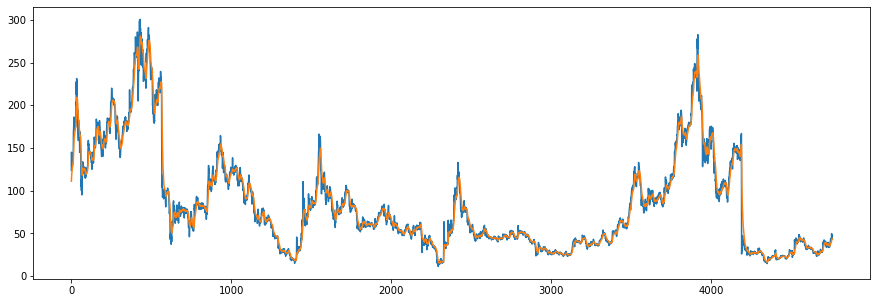

(4745, 15, 4)

In [60]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []

seed = 10
df = pd.read_csv('variation 7/initial_indicators/NVAX_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
    
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)

X.shape

In [61]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [62]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [63]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [64]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [65]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    nr_log  = pd.DataFrame(columns = column_names)
    r_log  = pd.DataFrame(columns = column_names)
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        callbacks=[tensorboard],
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    test_sets = ['VXRT','INO','NVAX']
    for name in test_sets:
        
        print('\n')
        print("Non-Recession")
        print('\n')
        
        X = nr_test_data['{}_X'.format(name)]
        y = nr_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("variation 7/initial_indicators/{}_data_test.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(nr_log)
        nr_log.loc[df_length] = logger
        print(nr_log.head(20))
        logger = []
        
        print('\n')
        print("Recession")
        print('\n')
        
        X = r_test_data['{}_X'.format(name)]
        y = r_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("variation 7/initial_indicators/{}_data_test2.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(r_log)
        r_log.loc[df_length] = logger
        print(r_log.head(20))
        logger = []

    nr_log.to_csv('{}_{}_{}epochs.csv'.format(experiment,'NovavaxModel',epochs))
    nr_log_hist['{}_epochs_logs'.format(epochs)] = nr_log
    r_log.to_csv('{}_{}_{}epochs.csv'.format(experiment,'NovavaxModel',epochs))
    r_log_hist['{}_epochs_logs'.format(epochs)] = r_log
    epochs = epochs + 20

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.57684630738523, 1: 7.272030651340996, 2: 0.36623251326579837}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 7s 218ms/step - loss: 0.2929 - accuracy: 0.5092 - mse: 0.4430 - weighted_accuracy: 0.3260 - weighted_mse: 0.5285 - val_loss: 0.2997 - val_accuracy: 0.0464 - val_mse: 0.3542 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.3542
Epoch 2/20
30/30 [==============================] - 1s 37ms/step - loss: 0.2075 - accuracy: 0.3272 - mse: 0.7843 - weighted_accuracy: 0.4777 - weighted_mse: 0.7607 - val_loss: 0.2906 - val_accuracy: 0.0464 - val_mse: 0.3862 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.3862
Epoch 3/20
30/30 [==============================] - 1s 36ms/step - loss: 0.1870 - accuracy: 0.2998 - mse: 1.0287 - weighted_accuracy: 0.4941 - weighted_mse: 1.0023 - val_loss: 0.2795 - val_accuracy: 0.0464 - val_mse: 0.4266 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.4266
Epoch 4/20
30/30 [==============================] - 1s

7/7 [==============================] - 0s 9ms/step - loss: 0.1898 - accuracy: 0.3607 - mse: 1.2654 - weighted_accuracy: 0.3607 - weighted_mse: 1.2654
Test loss: 0.18982325494289398
Test accuracy: 0.3607305884361267


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 3
actual sells but predicted hold: 4
actual holds but predicted buy: 74
actual holds but predicted sell: 59
actual predicted holds: 70
Percentage buys correct: 7.407407407407407%
Percentage sells correct: 4.761904761904762%
Percentage holds correct: 93.33333333333333%
actual buys: 8
actual sells: 8
actual holds: 203


Percentage low buys correct: 49.382716049382715%
Percentage high sells correct: 46.03174603174603%
Percentage mid holds correct: 83.78378378378379%


Capital: 100
Share price: $0.06210295522310325
Shares owned at the moment: 1605
Cash capital at the moment: $0.050649948303302494


Pri

7/7 [==============================] - 0s 12ms/step - loss: 0.1761 - accuracy: 0.4886 - mse: 1.1988 - weighted_accuracy: 0.4886 - weighted_mse: 1.1988
Test loss: 0.17606221139431
Test accuracy: 0.4885844886302948


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 4
actual holds but predicted buy: 55
actual holds but predicted sell: 49
actual predicted holds: 96
Percentage buys correct: 8.19672131147541%
Percentage sells correct: 10.909090909090908%
Percentage holds correct: 93.20388349514563%
actual buys: 8
actual sells: 11
actual holds: 200


Percentage low buys correct: 48.333333333333336%
Percentage high sells correct: 47.27272727272727%
Percentage mid holds correct: 87.37864077669903%


Capital: 100
Share price: $0.011763675119632519
Shares owned at the moment: 8477
Cash capital at the moment: $0.005094157405039823


Pri

7/7 [==============================] - 0s 12ms/step - loss: 0.1808 - accuracy: 0.4384 - mse: 1.1734 - weighted_accuracy: 0.4384 - weighted_mse: 1.1734
Test loss: 0.18084095418453217
Test accuracy: 0.4383561611175537


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 3
actual holds but predicted buy: 59
actual holds but predicted sell: 55
actual predicted holds: 87
Percentage buys correct: 4.761904761904762%
Percentage sells correct: 9.67741935483871%
Percentage holds correct: 92.55319148936171%
actual buys: 8
actual sells: 10
actual holds: 201


Percentage low buys correct: 44.44444444444444%
Percentage high sells correct: 53.225806451612904%
Percentage mid holds correct: 83.87096774193549%


Capital: 100
Share price: $0.03179487113936676
Shares owned at the moment: 3136
Cash capital at the moment: $0.01708513823994906


Pri

30/30 [==============================] - 1s 27ms/step - loss: 0.1303 - accuracy: 0.4452 - mse: 1.6510 - weighted_accuracy: 0.7352 - weighted_mse: 1.5625 - val_loss: 0.1838 - val_accuracy: 0.4131 - val_mse: 1.5639 - val_weighted_accuracy: 0.4131 - val_weighted_mse: 1.5639
Epoch 16/20
30/30 [==============================] - 1s 18ms/step - loss: 0.1302 - accuracy: 0.4884 - mse: 1.6705 - weighted_accuracy: 0.7511 - weighted_mse: 1.5968 - val_loss: 0.1899 - val_accuracy: 0.3952 - val_mse: 1.6915 - val_weighted_accuracy: 0.3952 - val_weighted_mse: 1.6915
Epoch 17/20
30/30 [==============================] - 1s 18ms/step - loss: 0.1301 - accuracy: 0.4650 - mse: 1.6952 - weighted_accuracy: 0.7442 - weighted_mse: 1.6125 - val_loss: 0.2007 - val_accuracy: 0.3456 - val_mse: 1.7006 - val_weighted_accuracy: 0.3456 - val_weighted_mse: 1.7006
Epoch 18/20
30/30 [==============================] - 1s 36ms/step - loss: 0.1280 - accuracy: 0.4663 - mse: 1.7064 - weighted_accuracy: 0.7449 - weighted_mse: 1.

7/7 [==============================] - 0s 13ms/step - loss: 0.1892 - accuracy: 0.3991 - mse: 1.6901 - weighted_accuracy: 0.3991 - weighted_mse: 1.6901
Test loss: 0.18923327326774597
Test accuracy: 0.39908257126808167


number of predictions: 218
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 2
actual predicted sells: 3
actual sells but predicted hold: 4
actual holds but predicted buy: 69
actual holds but predicted sell: 53
actual predicted holds: 77
Percentage buys correct: 8.974358974358974%
Percentage sells correct: 5.357142857142857%
Percentage holds correct: 91.66666666666667%
actual buys: 10
actual sells: 9
actual holds: 199


Percentage low buys correct: 48.717948717948715%
Percentage high sells correct: 60.0%
Percentage mid holds correct: 82.14285714285714%


Capital: 100
Share price: $0.9879411977395466
Shares owned at the moment: 100
Cash capital at the moment: $0.9341963966669624


Price increase fr

profit gained: 442.4367095588505%


Capital at the end of test period if Buy and Hold: $2186.7819938452512
profit gained: 2086.7819938452512%
   Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.474886      7.812500       5.660377      94.117647   
1       0.474886      5.769231       8.196721      90.566038   

   correct_low_buys  correct_high_sells  correct_mid_holds  Profit gained  \
0         50.000000           41.509434          87.128713     182.028719   
1         57.692308           42.622951          85.714286     442.436710   

   buy_n_hold profit  
0        3138.165411  
1        2086.781994  


Non-Recession


7/7 [==============================] - 0s 12ms/step - loss: 0.1801 - accuracy: 0.4541 - mse: 1.6998 - weighted_accuracy: 0.4541 - weighted_mse: 1.6998
Test loss: 0.1801147609949112
Test accuracy: 0.4541284441947937


number of predictions: 218
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 5
actual se




RUNNING EPOCHS 40 - 60



Epoch 1/20
30/30 [==============================] - 2s 62ms/step - loss: 0.1255 - accuracy: 0.5179 - mse: 1.7363 - weighted_accuracy: 0.7582 - weighted_mse: 1.6722 - val_loss: 0.1973 - val_accuracy: 0.3720 - val_mse: 1.7050 - val_weighted_accuracy: 0.3720 - val_weighted_mse: 1.7050
Epoch 2/20
30/30 [==============================] - 1s 35ms/step - loss: 0.1237 - accuracy: 0.5011 - mse: 1.7298 - weighted_accuracy: 0.7710 - weighted_mse: 1.6575 - val_loss: 0.1628 - val_accuracy: 0.5564 - val_mse: 1.6944 - val_weighted_accuracy: 0.5564 - val_weighted_mse: 1.6944
Epoch 3/20
30/30 [==============================] - 1s 35ms/step - loss: 0.1224 - accuracy: 0.5158 - mse: 1.7480 - weighted_accuracy: 0.7704 - weighted_mse: 1.6747 - val_loss: 0.1926 - val_accuracy: 0.4110 - val_mse: 1.8171 - val_weighted_accuracy: 0.4110 - val_weighted_mse: 1.8171
Epoch 4/20
30/30 [==============================] - 1s 27ms/step - loss: 0.1222 - accuracy: 0.5190 - mse: 1.7714 - weighte

7/7 [==============================] - 0s 6ms/step - loss: 0.1791 - accuracy: 0.5708 - mse: 2.1713 - weighted_accuracy: 0.5708 - weighted_mse: 2.1713
Test loss: 0.17907913029193878
Test accuracy: 0.5707762837409973


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 5
actual holds but predicted buy: 45
actual holds but predicted sell: 39
actual predicted holds: 119
Percentage buys correct: 8.0%
Percentage sells correct: 4.761904761904762%
Percentage holds correct: 93.7007874015748%
actual buys: 8
actual sells: 8
actual holds: 203


Percentage low buys correct: 54.0%
Percentage high sells correct: 43.90243902439025%
Percentage mid holds correct: 88.18897637795276%


Capital: 100
Share price: $0.025065914582985994
Shares owned at the moment: 3978
Cash capital at the moment: $0.013583216301142897


Price increase from previously

7/7 [==============================] - 0s 6ms/step - loss: 0.1609 - accuracy: 0.5845 - mse: 2.0447 - weighted_accuracy: 0.5845 - weighted_mse: 2.0447
Test loss: 0.16089753806591034
Test accuracy: 0.5844748616218567


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 33
actual holds but predicted sell: 43
actual predicted holds: 124
Percentage buys correct: 5.555555555555555%
Percentage sells correct: 4.444444444444445%
Percentage holds correct: 89.85507246376811%
actual buys: 8
actual sells: 11
actual holds: 200


Percentage low buys correct: 52.77777777777778%
Percentage high sells correct: 35.55555555555556%
Percentage mid holds correct: 84.67153284671532%


Capital: 100
Share price: $0.011763675119632519
Shares owned at the moment: 8477
Cash capital at the moment: $0.005094157405039823


P

Epoch 1/20
30/30 [==============================] - 1s 42ms/step - loss: 0.1065 - accuracy: 0.6291 - mse: 2.0698 - weighted_accuracy: 0.8251 - weighted_mse: 2.0374 - val_loss: 0.1907 - val_accuracy: 0.4752 - val_mse: 2.1386 - val_weighted_accuracy: 0.4752 - val_weighted_mse: 2.1386
Epoch 2/20
30/30 [==============================] - 1s 25ms/step - loss: 0.1044 - accuracy: 0.6238 - mse: 2.0649 - weighted_accuracy: 0.8416 - weighted_mse: 2.0295 - val_loss: 0.1632 - val_accuracy: 0.6017 - val_mse: 2.1641 - val_weighted_accuracy: 0.6017 - val_weighted_mse: 2.1641
Epoch 3/20
30/30 [==============================] - 1s 22ms/step - loss: 0.1032 - accuracy: 0.6341 - mse: 2.1012 - weighted_accuracy: 0.8341 - weighted_mse: 2.0600 - val_loss: 0.1846 - val_accuracy: 0.5184 - val_mse: 2.2191 - val_weighted_accuracy: 0.5184 - val_weighted_mse: 2.2191
Epoch 4/20
30/30 [==============================] - 1s 25ms/step - loss: 0.1031 - accuracy: 0.6370 - mse: 2.1269 - weighted_accuracy: 0.8353 - weighted

7/7 [==============================] - 0s 8ms/step - loss: 0.1729 - accuracy: 0.6256 - mse: 2.7463 - weighted_accuracy: 0.6256 - weighted_mse: 2.7463
Test loss: 0.17285548150539398
Test accuracy: 0.6255707740783691


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 6
actual holds but predicted buy: 42
actual holds but predicted sell: 30
actual predicted holds: 131
Percentage buys correct: 8.695652173913043%
Percentage sells correct: 6.0606060606060606%
Percentage holds correct: 93.57142857142857%
actual buys: 8
actual sells: 8
actual holds: 203


Percentage low buys correct: 56.52173913043478%
Percentage high sells correct: 46.875%
Percentage mid holds correct: 87.14285714285714%


Capital: 100
Share price: $0.018788448926188438
Shares owned at the moment: 5307
Cash capital at the moment: $0.015498227976934231


Price increa

7/7 [==============================] - 0s 7ms/step - loss: 0.1620 - accuracy: 0.6073 - mse: 2.5731 - weighted_accuracy: 0.6073 - weighted_mse: 2.5731
Test loss: 0.16201676428318024
Test accuracy: 0.6073059439659119


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 33
actual holds but predicted sell: 38
actual predicted holds: 129
Percentage buys correct: 5.555555555555555%
Percentage sells correct: 5.0%
Percentage holds correct: 90.20979020979021%
actual buys: 8
actual sells: 11
actual holds: 200


Percentage low buys correct: 52.77777777777778%
Percentage high sells correct: 35.0%
Percentage mid holds correct: 85.21126760563381%


Capital: 100
Share price: $0.011763675119632519
Shares owned at the moment: 8477
Cash capital at the moment: $0.005094157405039823


Price increase from previous


RUNNING EPOCHS 80 - 100



Epoch 1/20
30/30 [==============================] - 1s 39ms/step - loss: 0.0882 - accuracy: 0.7171 - mse: 2.5497 - weighted_accuracy: 0.8665 - weighted_mse: 2.5394 - val_loss: 0.1874 - val_accuracy: 0.5342 - val_mse: 2.6557 - val_weighted_accuracy: 0.5342 - val_weighted_mse: 2.6557
Epoch 2/20
30/30 [==============================] - 1s 21ms/step - loss: 0.0866 - accuracy: 0.7107 - mse: 2.5439 - weighted_accuracy: 0.8790 - weighted_mse: 2.5237 - val_loss: 0.1688 - val_accuracy: 0.6143 - val_mse: 2.7392 - val_weighted_accuracy: 0.6143 - val_weighted_mse: 2.7392
Epoch 3/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0855 - accuracy: 0.7237 - mse: 2.6105 - weighted_accuracy: 0.8819 - weighted_mse: 2.5811 - val_loss: 0.1833 - val_accuracy: 0.5701 - val_mse: 2.7528 - val_weighted_accuracy: 0.5701 - val_weighted_mse: 2.7528
Epoch 4/20
30/30 [==============================] - 1s 22ms/step - loss: 0.0858 - accuracy: 0.7313 - mse: 2.6196 - weighted

7/7 [==============================] - 0s 4ms/step - loss: 0.1649 - accuracy: 0.6575 - mse: 3.4965 - weighted_accuracy: 0.6575 - weighted_mse: 3.4965
Test loss: 0.16493402421474457
Test accuracy: 0.6575342416763306


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 7
actual holds but predicted buy: 38
actual holds but predicted sell: 25
actual predicted holds: 140
Percentage buys correct: 7.317073170731708%
Percentage sells correct: 3.7037037037037037%
Percentage holds correct: 92.71523178807946%
actual buys: 8
actual sells: 8
actual holds: 203


Percentage low buys correct: 53.65853658536585%
Percentage high sells correct: 46.15384615384615%
Percentage mid holds correct: 84.76821192052981%


Capital: 100
Share price: $0.018788448926188438
Shares owned at the moment: 5307
Cash capital at the moment: $0.015498227976934231


P

1        2086.781994  


Non-Recession


7/7 [==============================] - 0s 4ms/step - loss: 0.1505 - accuracy: 0.6972 - mse: 3.0499 - weighted_accuracy: 0.6972 - weighted_mse: 3.0499
Test loss: 0.15051454305648804
Test accuracy: 0.6972476840019226


number of predictions: 218
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 5
actual holds but predicted buy: 32
actual holds but predicted sell: 19
actual predicted holds: 150
Percentage buys correct: 0.0%
Percentage sells correct: 9.523809523809524%
Percentage holds correct: 91.46341463414635%
actual buys: 9
actual sells: 8
actual holds: 201


Percentage low buys correct: 31.25%
Percentage high sells correct: 52.38095238095238%
Percentage mid holds correct: 84.14634146341463%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price i

30/30 [==============================] - 1s 24ms/step - loss: 0.0705 - accuracy: 0.7864 - mse: 3.2183 - weighted_accuracy: 0.9124 - weighted_mse: 3.1670 - val_loss: 0.1718 - val_accuracy: 0.6459 - val_mse: 3.4680 - val_weighted_accuracy: 0.6459 - val_weighted_mse: 3.4680
Epoch 3/20
30/30 [==============================] - 1s 22ms/step - loss: 0.0701 - accuracy: 0.7861 - mse: 3.2997 - weighted_accuracy: 0.9104 - weighted_mse: 3.2298 - val_loss: 0.1834 - val_accuracy: 0.6143 - val_mse: 3.4682 - val_weighted_accuracy: 0.6143 - val_weighted_mse: 3.4682
Epoch 4/20
30/30 [==============================] - 1s 23ms/step - loss: 0.0701 - accuracy: 0.7972 - mse: 3.3175 - weighted_accuracy: 0.9144 - weighted_mse: 3.2274 - val_loss: 0.1640 - val_accuracy: 0.6881 - val_mse: 3.7317 - val_weighted_accuracy: 0.6881 - val_weighted_mse: 3.7317
Epoch 5/20
30/30 [==============================] - 1s 22ms/step - loss: 0.0699 - accuracy: 0.7808 - mse: 3.3795 - weighted_accuracy: 0.9087 - weighted_mse: 3.341

7/7 [==============================] - 0s 3ms/step - loss: 0.1522 - accuracy: 0.6849 - mse: 4.4545 - weighted_accuracy: 0.6849 - weighted_mse: 4.4545
Test loss: 0.15219609439373016
Test accuracy: 0.6849315166473389


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 7
actual holds but predicted buy: 35
actual holds but predicted sell: 22
actual predicted holds: 146
Percentage buys correct: 7.894736842105263%
Percentage sells correct: 4.166666666666667%
Percentage holds correct: 92.99363057324841%
actual buys: 8
actual sells: 8
actual holds: 203


Percentage low buys correct: 52.63157894736842%
Percentage high sells correct: 39.130434782608695%
Percentage mid holds correct: 84.71337579617834%


Capital: 100
Share price: $0.018788448926188438
Shares owned at the moment: 5307
Cash capital at the moment: $0.015498227976934231


P

Cash capital at the moment: $372.666990459934


Share price: $0.30135803480391465
Shares owned at the moment: 1233
Cash capital at the moment: $0.07070379019586426


Price increase from previously bought: 13.96644533017306%
Share price: $0.34439151934284024
Shares owned at the moment: 0
Cash capital at the moment: $423.5377015957061


Share price: $0.2703174670720192
Shares owned at the moment: 1562
Cash capital at the moment: $0.14066934940422016




Capital at the end of test period: $403.08339877165446
profit gained: 303.08339877165446%


Capital at the end of test period if Buy and Hold: $2186.7819938452512
profit gained: 2086.7819938452512%
   Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.684932      7.894737       4.166667      92.993631   
1       0.721461      0.000000       3.333333      89.714286   

   correct_low_buys  correct_high_sells  correct_mid_holds  Profit gained  \
0         52.631579           39.130435          84.713376     393.069836   

30/30 [==============================] - 0s 14ms/step - loss: 0.0574 - accuracy: 0.8369 - mse: 4.1072 - weighted_accuracy: 0.9347 - weighted_mse: 3.9876 - val_loss: 0.1741 - val_accuracy: 0.6765 - val_mse: 4.2485 - val_weighted_accuracy: 0.6765 - val_weighted_mse: 4.2485
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0572 - accuracy: 0.8361 - mse: 4.0850 - weighted_accuracy: 0.9344 - weighted_mse: 3.9357 - val_loss: 0.1713 - val_accuracy: 0.7092 - val_mse: 4.5037 - val_weighted_accuracy: 0.7092 - val_weighted_mse: 4.5037
Epoch 3/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0566 - accuracy: 0.8335 - mse: 4.1980 - weighted_accuracy: 0.9353 - weighted_mse: 4.0120 - val_loss: 0.1800 - val_accuracy: 0.6744 - val_mse: 4.2795 - val_weighted_accuracy: 0.6744 - val_weighted_mse: 4.2795
Epoch 4/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0563 - accuracy: 0.8422 - mse: 4.2443 - weighted_accuracy: 0.9328 - weighted_mse: 4.0401 

7/7 [==============================] - 0s 3ms/step - loss: 0.1481 - accuracy: 0.7306 - mse: 5.7823 - weighted_accuracy: 0.7306 - weighted_mse: 5.7823
Test loss: 0.14808540046215057
Test accuracy: 0.7305936217308044


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 6
actual holds but predicted buy: 27
actual holds but predicted sell: 21
actual predicted holds: 155
Percentage buys correct: 10.0%
Percentage sells correct: 8.333333333333334%
Percentage holds correct: 93.93939393939394%
actual buys: 8
actual sells: 8
actual holds: 203


Percentage low buys correct: 56.666666666666664%
Percentage high sells correct: 39.130434782608695%
Percentage mid holds correct: 85.45454545454545%


Capital: 100
Share price: $0.018788448926188438
Shares owned at the moment: 5307
Cash capital at the moment: $0.015498227976934231


Price increas

7/7 [==============================] - 0s 3ms/step - loss: 0.1491 - accuracy: 0.8028 - mse: 5.1341 - weighted_accuracy: 0.8028 - weighted_mse: 5.1341
Test loss: 0.1490950584411621
Test accuracy: 0.8027523159980774


number of predictions: 218
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 5
actual holds but predicted buy: 20
actual holds but predicted sell: 8
actual predicted holds: 173
Percentage buys correct: 0.0%
Percentage sells correct: 20.0%
Percentage holds correct: 92.51336898395722%
actual buys: 9
actual sells: 8
actual holds: 201


Percentage low buys correct: 40.0%
Percentage high sells correct: 80.0%
Percentage mid holds correct: 84.49197860962566%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from previously bought: -81.59684283385067%
Share price: $0.18

Epoch 7/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0461 - accuracy: 0.8728 - mse: 5.4521 - weighted_accuracy: 0.9460 - weighted_mse: 5.1308 - val_loss: 0.2185 - val_accuracy: 0.6523 - val_mse: 5.5152 - val_weighted_accuracy: 0.6523 - val_weighted_mse: 5.5152
Epoch 8/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0438 - accuracy: 0.8836 - mse: 5.4628 - weighted_accuracy: 0.9498 - weighted_mse: 5.1248 - val_loss: 0.1773 - val_accuracy: 0.7619 - val_mse: 6.0722 - val_weighted_accuracy: 0.7619 - val_weighted_mse: 6.0722
Epoch 9/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0449 - accuracy: 0.8759 - mse: 5.6194 - weighted_accuracy: 0.9491 - weighted_mse: 5.2307 - val_loss: 0.1840 - val_accuracy: 0.7229 - val_mse: 5.7149 - val_weighted_accuracy: 0.7229 - val_weighted_mse: 5.7149
Epoch 10/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0427 - accuracy: 0.8846 - mse: 5.7192 - weighted_accuracy: 0.9541 - weighted

Cash capital at the moment: $3182.7624354938353


Share price: $0.3006465977981677
Shares owned at the moment: 10557
Cash capital at the moment: $0.10800567295154906


Price increase from previously bought: -11.726688264764086%
Share price: $0.26612053294412086
Shares owned at the moment: 0
Cash capital at the moment: $2801.8165271817347


Share price: $0.26298181882402316
Shares owned at the moment: 10624
Cash capital at the moment: $0.21440717654968466


Price increase from previously bought: 48.52573450850333%
Share price: $0.3916698161467904
Shares owned at the moment: 0
Cash capital at the moment: $4149.871508571507




Capital at the end of test period: $4149.871508571507
profit gained: 4049.871508571507%


Capital at the end of test period if Buy and Hold: $3238.165410975435
profit gained: 3138.165410975435%
   Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.739726      6.896552      13.043478      94.011976   

   correct_low_buys  correct_high_sells  cor

7/7 [==============================] - 0s 4ms/step - loss: 0.2269 - accuracy: 0.7352 - mse: 6.2381 - weighted_accuracy: 0.7352 - weighted_mse: 6.2381
Test loss: 0.22693920135498047
Test accuracy: 0.7351598143577576


number of predictions: 219
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 10
actual holds but predicted buy: 16
actual holds but predicted sell: 24
actual predicted holds: 161
Percentage buys correct: 0.0%
Percentage sells correct: 0.0%
Percentage holds correct: 89.94413407821229%
actual buys: 8
actual sells: 10
actual holds: 201


Percentage low buys correct: 50.0%
Percentage high sells correct: 41.666666666666664%
Percentage mid holds correct: 83.70786516853933%


Capital: 100
Share price: $0.03179487113936676
Shares owned at the moment: 3136
Cash capital at the moment: $0.01708513823994906


Price increase from previously bought: 53.

Epoch 18/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0341 - accuracy: 0.9091 - mse: 7.4020 - weighted_accuracy: 0.9630 - weighted_mse: 6.6729 - val_loss: 0.2307 - val_accuracy: 0.7208 - val_mse: 7.4557 - val_weighted_accuracy: 0.7208 - val_weighted_mse: 7.4557
Epoch 19/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0318 - accuracy: 0.9154 - mse: 7.6299 - weighted_accuracy: 0.9690 - weighted_mse: 6.8130 - val_loss: 0.2013 - val_accuracy: 0.7935 - val_mse: 8.2878 - val_weighted_accuracy: 0.7935 - val_weighted_mse: 8.2878
Epoch 20/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0303 - accuracy: 0.9215 - mse: 7.8534 - weighted_accuracy: 0.9657 - weighted_mse: 7.0111 - val_loss: 0.2004 - val_accuracy: 0.7924 - val_mse: 8.1223 - val_weighted_accuracy: 0.7924 - val_weighted_mse: 8.1223
Validation loss: 0.2004460096359253
Validation accuracy: 0.792413055896759


Non-Recession


7/7 [==============================] - 0s 3ms/step - lo

1         -73.870573  


Recession


7/7 [==============================] - 0s 3ms/step - loss: 0.2024 - accuracy: 0.7991 - mse: 8.4326 - weighted_accuracy: 0.7991 - weighted_mse: 8.4326
Test loss: 0.20237921178340912
Test accuracy: 0.7990867495536804


number of predictions: 219
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 10
actual holds but predicted buy: 9
actual holds but predicted sell: 17
actual predicted holds: 174
Percentage buys correct: 0.0%
Percentage sells correct: 5.555555555555555%
Percentage holds correct: 90.625%
actual buys: 8
actual sells: 11
actual holds: 200


Percentage low buys correct: 66.66666666666667%
Percentage high sells correct: 44.44444444444444%
Percentage mid holds correct: 85.86387434554973%


Capital: 100
Share price: $0.011763675119632519
Shares owned at the moment: 8477
Cash capital at the moment: $0.0050941574

2        5802.379195  



RUNNING EPOCHS 180 - 200



Epoch 1/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0311 - accuracy: 0.9197 - mse: 7.9024 - weighted_accuracy: 0.9706 - weighted_mse: 7.1024 - val_loss: 0.2078 - val_accuracy: 0.7893 - val_mse: 8.5910 - val_weighted_accuracy: 0.7893 - val_weighted_mse: 8.5910
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0321 - accuracy: 0.9194 - mse: 7.8453 - weighted_accuracy: 0.9668 - weighted_mse: 7.0037 - val_loss: 0.2086 - val_accuracy: 0.7819 - val_mse: 8.4047 - val_weighted_accuracy: 0.7819 - val_weighted_mse: 8.4047
Epoch 3/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0318 - accuracy: 0.9183 - mse: 7.9221 - weighted_accuracy: 0.9701 - weighted_mse: 6.9812 - val_loss: 0.2150 - val_accuracy: 0.7619 - val_mse: 8.1362 - val_weighted_accuracy: 0.7619 - val_weighted_mse: 8.1362
Epoch 4/20
30/30 [==============================] - 0s 11ms/step - loss: 0.0317 - accuracy: 0.9218

7/7 [==============================] - 0s 3ms/step - loss: 0.1793 - accuracy: 0.7808 - mse: 10.5832 - weighted_accuracy: 0.7808 - weighted_mse: 10.5832
Test loss: 0.17930740118026733
Test accuracy: 0.7808219194412231


number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 6
actual holds but predicted buy: 19
actual holds but predicted sell: 16
actual predicted holds: 168
Percentage buys correct: 5.0%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 92.81767955801105%
actual buys: 8
actual sells: 8
actual holds: 203


Percentage low buys correct: 60.0%
Percentage high sells correct: 47.05882352941177%
Percentage mid holds correct: 84.5303867403315%


Capital: 100
Share price: $0.05017576972685583
Shares owned at the moment: 1987
Cash capital at the moment: $0.026572603007494422


Price increase from previousl

1        2086.781994  


Non-Recession


7/7 [==============================] - 0s 4ms/step - loss: 0.1869 - accuracy: 0.8119 - mse: 9.3067 - weighted_accuracy: 0.8119 - weighted_mse: 9.3067
Test loss: 0.18691487610340118
Test accuracy: 0.8119266033172607


number of predictions: 218
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 1
actual predicted sells: 0
actual sells but predicted hold: 7
actual holds but predicted buy: 16
actual holds but predicted sell: 8
actual predicted holds: 177
Percentage buys correct: 0.0%
Percentage sells correct: 0.0%
Percentage holds correct: 91.70984455958549%
actual buys: 9
actual sells: 8
actual holds: 201


Percentage low buys correct: 43.75%
Percentage high sells correct: 62.5%
Percentage mid holds correct: 83.41968911917098%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from previously boug

In [66]:
Vaxart_data_acc = []
Inovio_data_acc = []
Novavax_data_acc = []

Vaxart_data_correct_buys = []
Inovio_data_correct_buys = []
Novavax_data_correct_buys = []

Vaxart_data_correct_sells = []
Inovio_data_correct_sells = []
Novavax_data_correct_sells = []

Vaxart_data_correct_holds = []
Inovio_data_correct_holds = []
Novavax_data_correct_holds = []

Vaxart_data_correct_low_buys = []
Inovio_data_correct_low_buys = []
Novavax_data_correct_low_buys = []

Vaxart_data_correct_high_sells = []
Inovio_data_correct_high_sells = []
Novavax_data_correct_high_sells = []

Vaxart_data_correct_mid_holds = []
Inovio_data_correct_mid_holds = []
Novavax_data_correct_mid_holds = []

Vaxart_data_profit = []
Inovio_data_profit = []
Novavax_data_profit = []

for key,value in nr_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    Vaxart_data_acc.append(acc[0])
    Inovio_data_acc.append(acc[1])
    Novavax_data_acc.append(acc[2])
    
    Vaxart_data_correct_buys.append(correct_buys[0])
    Inovio_data_correct_buys.append(correct_buys[1]) 
    Novavax_data_correct_buys.append(correct_buys[2]) 

    Vaxart_data_correct_sells.append(correct_sells[0]) 
    Inovio_data_correct_sells.append(correct_sells[1]) 
    Novavax_data_correct_sells.append(correct_sells[2]) 

    Vaxart_data_correct_holds.append(correct_holds[0]) 
    Inovio_data_correct_holds.append(correct_holds[1])  
    Novavax_data_correct_holds.append(correct_holds[2])  

    Vaxart_data_correct_low_buys.append(correct_low_buys[0])  
    Inovio_data_correct_low_buys.append(correct_low_buys[1])  
    Novavax_data_correct_low_buys.append(correct_low_buys[2])  

    Vaxart_data_correct_high_sells.append(correct_high_sells[0]) 
    Inovio_data_correct_high_sells.append(correct_high_sells[1]) 
    Novavax_data_correct_high_sells.append(correct_high_sells[2]) 

    Vaxart_data_correct_mid_holds.append(correct_mid_holds[0])  
    Inovio_data_correct_mid_holds.append(correct_mid_holds[1])  
    Novavax_data_correct_mid_holds.append(correct_mid_holds[2])   

    Vaxart_data_profit.append(profit[0]) 
    Inovio_data_profit.append(profit[1]) 
    Novavax_data_profit.append(profit[2])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


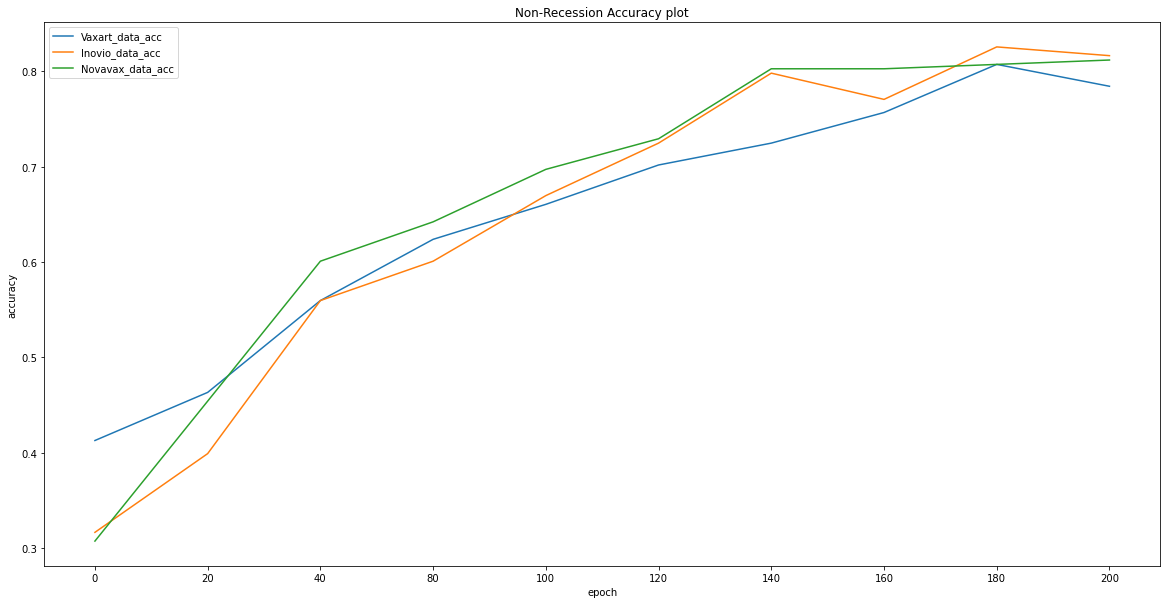

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(Vaxart_data_acc)
plt.plot(Inovio_data_acc)
plt.plot(Novavax_data_acc)

plt.title('Non-Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Vaxart_data_acc','Inovio_data_acc','Novavax_data_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Novavax_data_correct_buys')

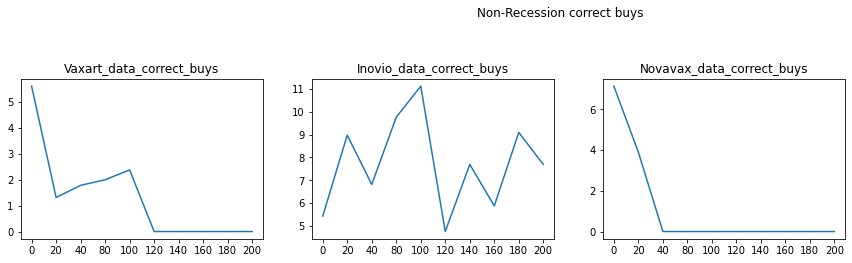

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(Vaxart_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Vaxart_data_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(Inovio_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Inovio_data_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(Novavax_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Novavax_data_correct_buys")

Text(0.5, 1.0, 'Novavax_data_correct_sells')

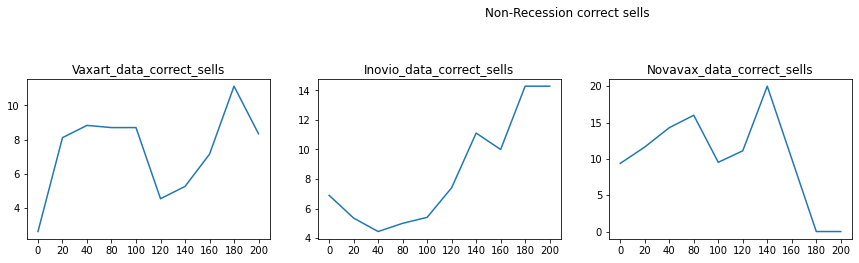

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(Vaxart_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Vaxart_data_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(Inovio_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Inovio_data_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(Novavax_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Novavax_data_correct_sells")

Text(0.5, 1.0, 'Novavax_data_correct_holds')

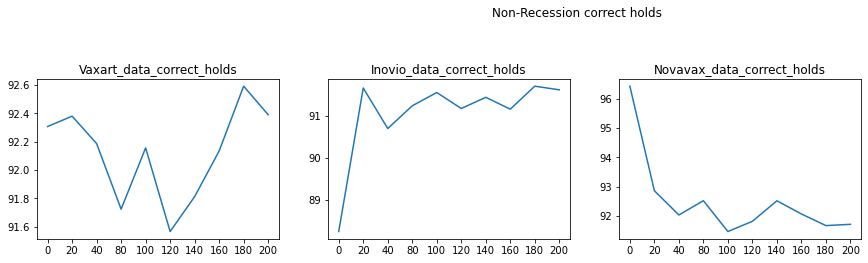

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(Vaxart_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Vaxart_data_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(Inovio_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Inovio_data_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(Novavax_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Novavax_data_correct_holds")

Text(0.5, 1.0, 'Novavax_data_correct_low_buys')

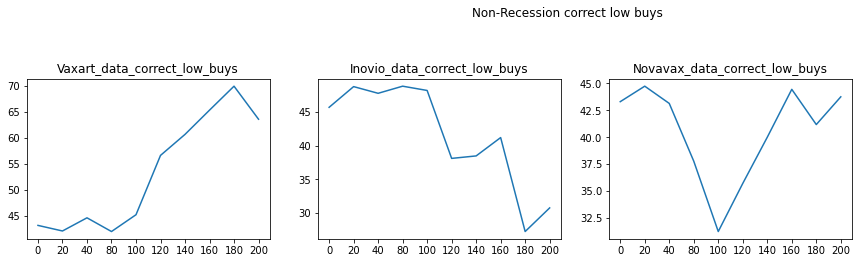

In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(Vaxart_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Vaxart_data_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(Inovio_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Inovio_data_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(Novavax_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Novavax_data_correct_low_buys")

Text(0.5, 1.0, 'Novavax_data_correct_high_sells')

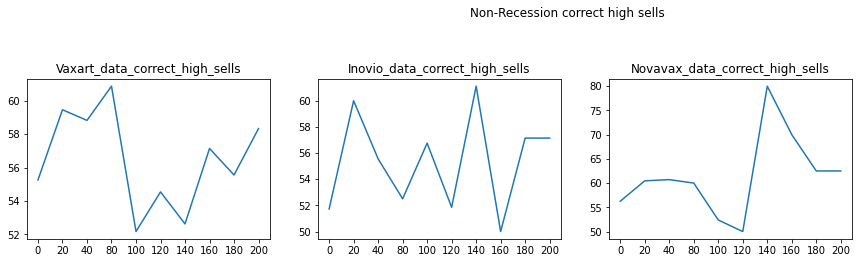

In [72]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(Vaxart_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Vaxart_data_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(Inovio_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Inovio_data_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(Novavax_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Novavax_data_correct_high_sells")

Text(0.5, 1.0, 'Novavax_data_correct_mid_holds')

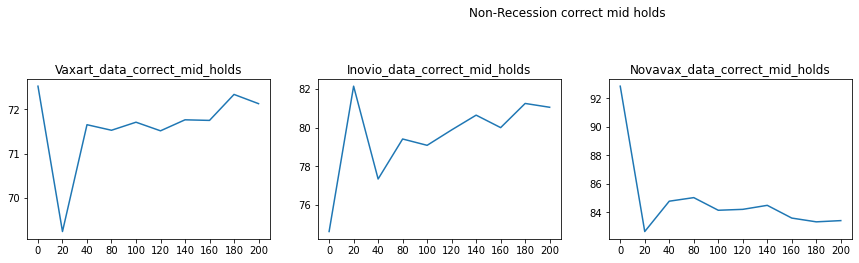

In [73]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(Vaxart_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Vaxart_data_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(Inovio_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Inovio_data_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(Novavax_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Novavax_data_correct_mid_holds")

Text(0.5, 1.0, 'Novavax_data_profit')

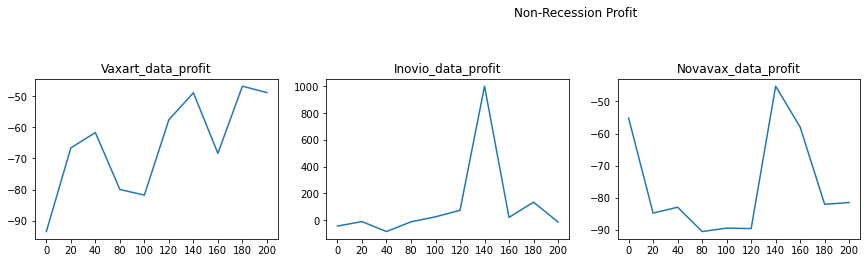

In [74]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(Vaxart_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Vaxart_data_profit")

plt.subplot(3, 4, 2)
plt.plot(Inovio_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Inovio_data_profit")

plt.subplot(3, 4, 3)
plt.plot(Novavax_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Novavax_data_profit")

In [75]:
Vaxart_data_acc = []
Inovio_data_acc = []
Novavax_data_acc = []

Vaxart_data_correct_buys = []
Inovio_data_correct_buys = []
Novavax_data_correct_buys = []

Vaxart_data_correct_sells = []
Inovio_data_correct_sells = []
Novavax_data_correct_sells = []

Vaxart_data_correct_holds = []
Inovio_data_correct_holds = []
Novavax_data_correct_holds = []

Vaxart_data_correct_low_buys = []
Inovio_data_correct_low_buys = []
Novavax_data_correct_low_buys = []

Vaxart_data_correct_high_sells = []
Inovio_data_correct_high_sells = []
Novavax_data_correct_high_sells = []

Vaxart_data_correct_mid_holds = []
Inovio_data_correct_mid_holds = []
Novavax_data_correct_mid_holds = []

Vaxart_data_profit = []
Inovio_data_profit = []
Novavax_data_profit = []

for key,value in r_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    Vaxart_data_acc.append(acc[0])
    Inovio_data_acc.append(acc[1])
    Novavax_data_acc.append(acc[2])
    
    Vaxart_data_correct_buys.append(correct_buys[0])
    Inovio_data_correct_buys.append(correct_buys[1]) 
    Novavax_data_correct_buys.append(correct_buys[2]) 

    Vaxart_data_correct_sells.append(correct_sells[0]) 
    Inovio_data_correct_sells.append(correct_sells[1]) 
    Novavax_data_correct_sells.append(correct_sells[2]) 

    Vaxart_data_correct_holds.append(correct_holds[0]) 
    Inovio_data_correct_holds.append(correct_holds[1])  
    Novavax_data_correct_holds.append(correct_holds[2])  

    Vaxart_data_correct_low_buys.append(correct_low_buys[0])  
    Inovio_data_correct_low_buys.append(correct_low_buys[1])  
    Novavax_data_correct_low_buys.append(correct_low_buys[2])  

    Vaxart_data_correct_high_sells.append(correct_high_sells[0]) 
    Inovio_data_correct_high_sells.append(correct_high_sells[1]) 
    Novavax_data_correct_high_sells.append(correct_high_sells[2]) 

    Vaxart_data_correct_mid_holds.append(correct_mid_holds[0])  
    Inovio_data_correct_mid_holds.append(correct_mid_holds[1])  
    Novavax_data_correct_mid_holds.append(correct_mid_holds[2])   

    Vaxart_data_profit.append(profit[0]) 
    Inovio_data_profit.append(profit[1]) 
    Novavax_data_profit.append(profit[2])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


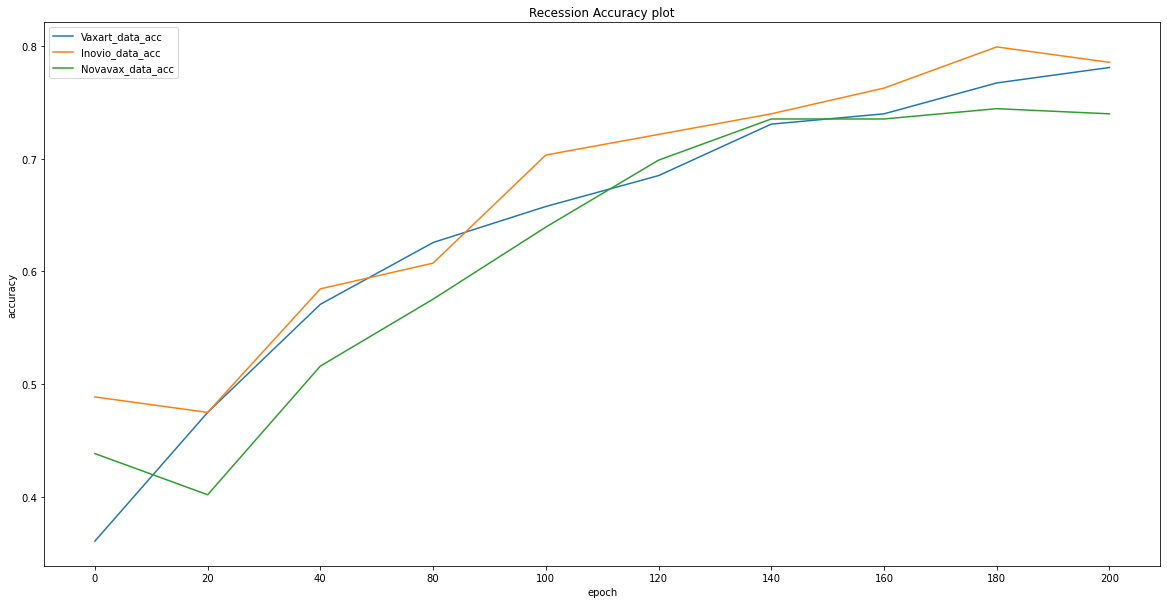

In [76]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(Vaxart_data_acc)
plt.plot(Inovio_data_acc)
plt.plot(Novavax_data_acc)

plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Vaxart_data_acc','Inovio_data_acc','Novavax_data_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Novavax_data_correct_buys')

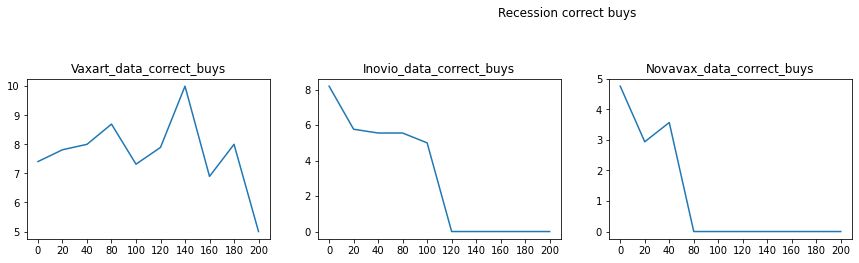

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(Vaxart_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Vaxart_data_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(Inovio_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Inovio_data_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(Novavax_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Novavax_data_correct_buys")

Text(0.5, 1.0, 'Novavax_data_correct_sells')

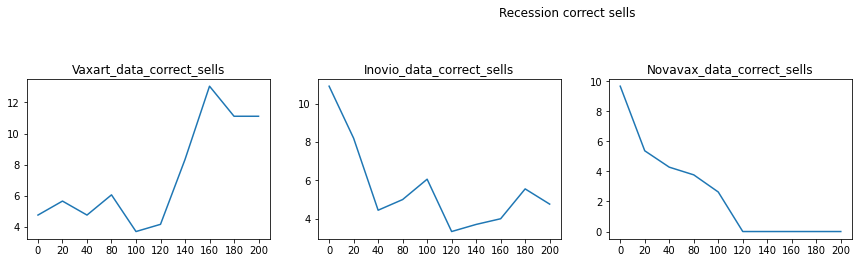

In [78]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(Vaxart_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Vaxart_data_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(Inovio_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Inovio_data_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(Novavax_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Novavax_data_correct_sells")

Text(0.5, 1.0, 'Novavax_data_correct_holds')

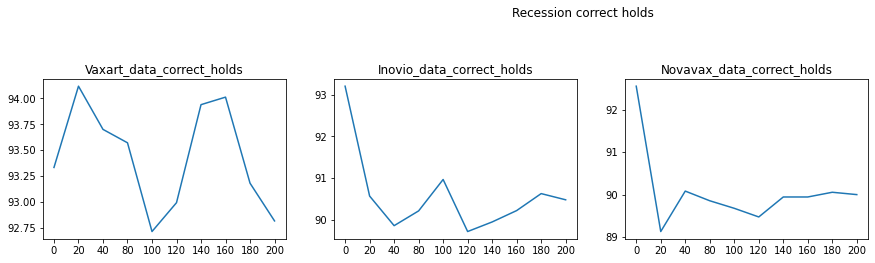

In [79]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(Vaxart_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Vaxart_data_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(Inovio_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Inovio_data_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(Novavax_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Novavax_data_correct_holds")

Text(0.5, 1.0, 'Novavax_data_correct_low_buys')

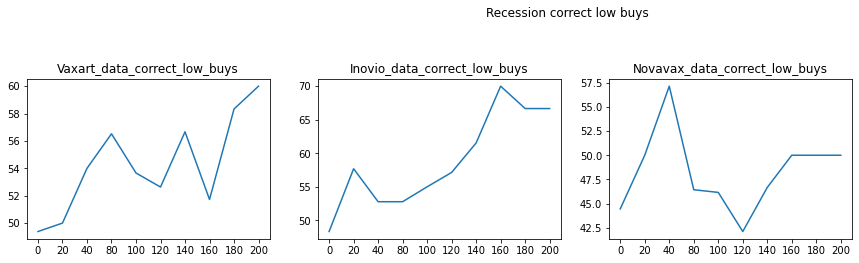

In [80]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(Vaxart_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Vaxart_data_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(Inovio_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Inovio_data_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(Novavax_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Novavax_data_correct_low_buys")

Text(0.5, 1.0, 'Novavax_data_correct_high_sells')

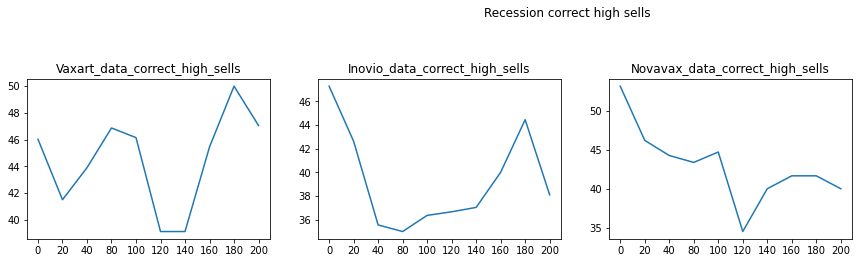

In [81]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(Vaxart_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Vaxart_data_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(Inovio_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Inovio_data_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(Novavax_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Novavax_data_correct_high_sells")

Text(0.5, 1.0, 'Novavax_data_correct_mid_holds')

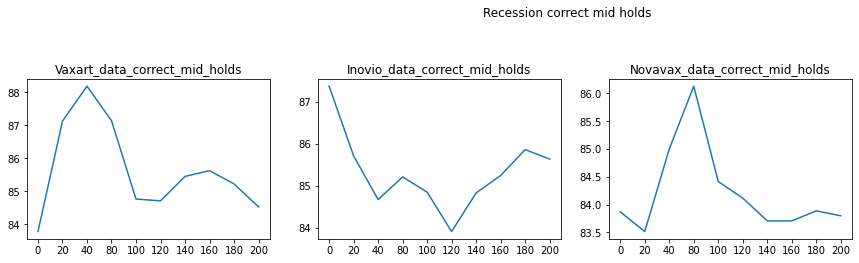

In [82]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(Vaxart_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Vaxart_data_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(Inovio_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Inovio_data_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(Novavax_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Novavax_data_correct_mid_holds")

Text(0.5, 1.0, 'Novavax_data_profit')

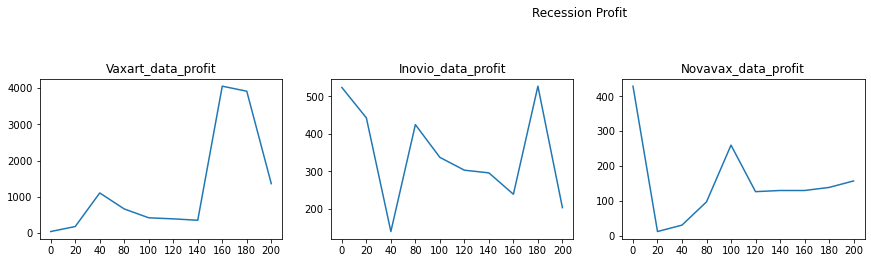

In [83]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(Vaxart_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Vaxart_data_profit")

plt.subplot(3, 4, 2)
plt.plot(Inovio_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Inovio_data_profit")

plt.subplot(3, 4, 3)
plt.plot(Novavax_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Novavax_data_profit")